In [ ]:
  #Required libraries
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers , callbacks
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, Dense
from keras.models import Model
#Random seed for reproducability
np.random.seed(42)
#Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family']      = 'STIXGeneral'

# Exercise 2:


# MNIST & CIFAR 10  Data-set. Classification Neural Network models and Adversarial examples
This Jupyter notebook contains code to solve  different tasks related to building, training and creating adversarial examples for classification moelds on the MNIST and CIFAR10 datasets. Specifically:

- Two Convolutional Neural Network (CNN) models to classify iamges in the MNIST and CIFAR10 datasets with test accuracy of $0.99\%$ and $0.80\%$ respectively.

- A generator class able to create fake images from noise for both datasets

- A composite model class that combines the generator and the dataset-specific frozen CNN classifier model. This composite model generates adversarial examples in the form of fake images that resemble the real training images but with added noise to mislead the model into misclassifying them as a different target class.


## Data loading & preproccesing
- First we load the MNIST  dataset, as we can see we have 60000 images of 28x28 pixels in the traning set, and 10000 images of 28x28 pixels in the test set. Thus the size of the test set is around 17% of the training set.
- Loading the CIFAR10 datset, we see that it has 50000 images of size 32x32,with 3 channels, so unlike the MNIST digit, they are colored images. The test set is 20% of the training set.

In [ ]:
#Load the Mnist dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# print the shapes of the training and testing data
print("MNIST Training data shape:", X_train.shape)
print("MNIST Test data shape:", X_test.shape)
print("MNIST Test set % split:", round((X_test.shape[0]/X_train.shape[0])*100,2),"% of the training set\n")

#Load the cifar10 dataset
(X_train_1, y_train_1), (X_test_1,y_test_1) = keras.datasets.cifar10.load_data()
print("CIFAR10 Training data shape:", X_train_1.shape)
print("CIFAR10 Test data shape:", X_test_1.shape)
print("CIFAR10 Test set % split:", round((X_test_1.shape[0]/X_train_1.shape[0])*100,2),"% of the training set")

11490434/11490434 [==============================] - 0s 0us/step
MNIST Training data shape: (60000, 28, 28)
MNIST Test data shape: (10000, 28, 28)
MNIST Test set % split: 16.67 % of the training set

170498071/170498071 [==============================] - 3s 0us/step
CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Test data shape: (10000, 32, 32, 3)
CIFAR10 Test set % split: 20.0 % of the training set


The target classes for MNIST are 10 digits from 0 to 9. Below some examples of the images in the dataset are shown.


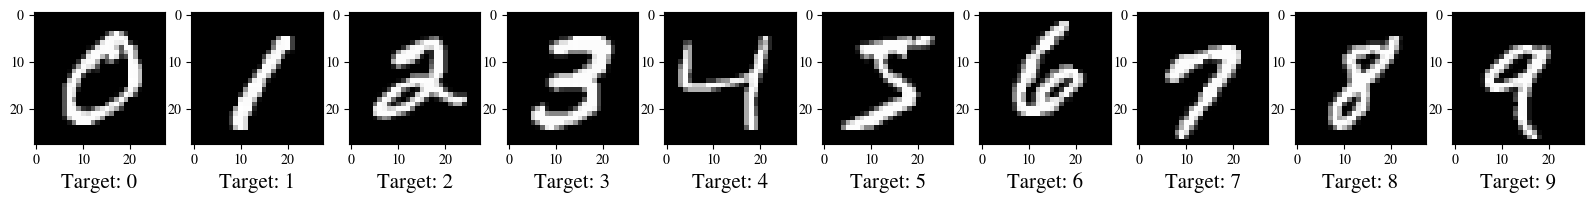

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    #Find the first occurence of the number i in the training set
    idx = np.where(y_train == i)[0][0]
    ax[i].imshow(X_train[idx],cmap=plt.get_cmap('gray'))
    ax[i].set_xlabel(f"Target: {y_train[idx]}",fontsize = 15)
plt.show()

Concerning the Cifar10 dataset it also contains 10 classes but this time they are tiny 32x32 colour images of: 
- Airplanes
- Automobiles
- Birds
- Cats
- Deers
- Dogs
- Frogs
- Horses
- Ships
- Trucks

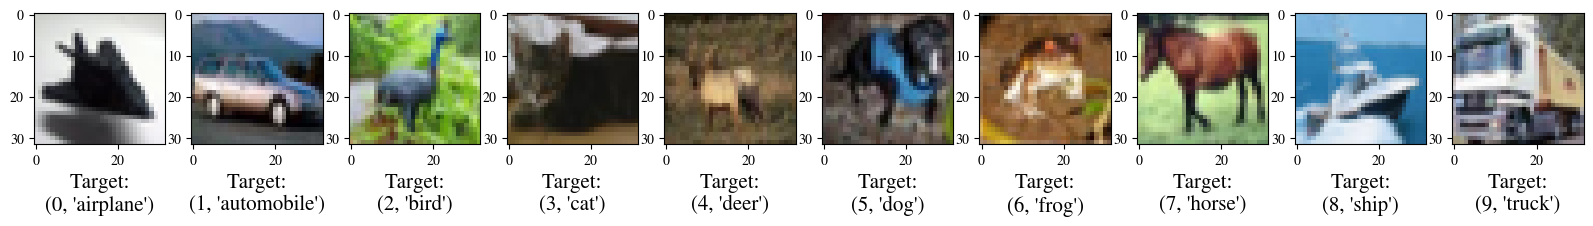

In [ ]:
classes = dict(zip(np.unique(y_train_1),['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i,description in enumerate(classes.values()):
    #Find the first occurence of the number i in the training set
    idx = np.where(y_train_1 == i)[0][0]
    ax[i].imshow(X_train_1[idx],cmap=plt.get_cmap('gray'))
    ax[i].set_xlabel(f"Target:\n{i,description}",fontsize = 15)
plt.show()

Inspecting the count of instances for each class on the MNIST and CIFAR10 dataset:
- The CIFAR10 has the same number of instances for all classes
- In the MNIST dataset the instances of digit "1" are around 1000 more than other classes. We could augment the dataset to decrease possible model bias but our focus is on creating adversarial examples

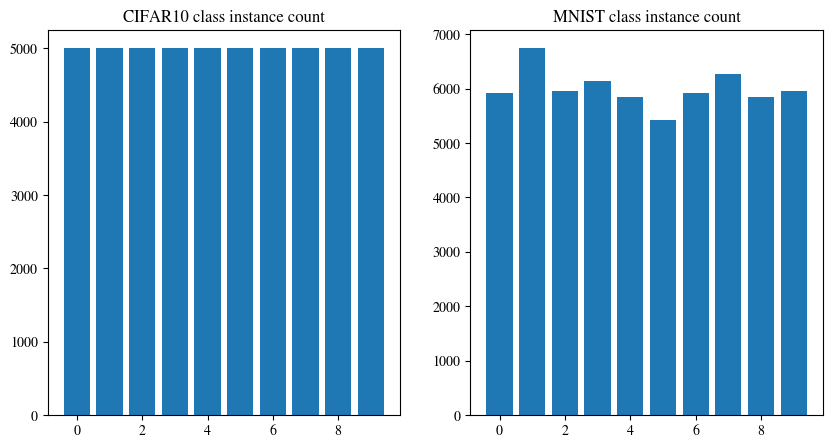

In [ ]:
unique_classes_mnist, class_counts_mnist = np.unique(y_train, return_counts=True)
unique_classes_cifar10, class_counts_cifar10 = np.unique(y_train_1, return_counts=True)
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].bar(unique_classes_cifar10,class_counts_cifar10)
ax[0].set_title("CIFAR10 class instance count")
ax[1].bar(unique_classes_mnist,class_counts_mnist)
ax[1].set_title("MNIST class instance count")
plt.show()

### Target Label One-Hot encoding 
Since we have a multi-label classification problem for both the CIFAR10 and MNIST dataset, we convert the labels of the classes $[0,9]$ to an one hot encoded from. This can achieved with `to_categorical` form the Keras np_utilities library. The new target labels are shown below.

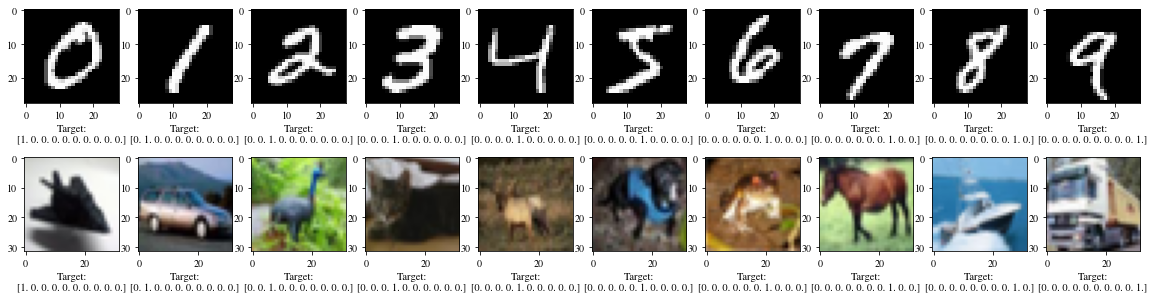

In [ ]:
from keras.utils import np_utils
class_num = 10
#MNIST
y_train = np_utils.to_categorical(y_train, class_num)
y_test = np_utils.to_categorical(y_test, class_num)
#CIFAR10
y_train_1 = np_utils.to_categorical(y_train_1, class_num)
y_test_1 = np_utils.to_categorical(y_test_1, class_num)
fig, ax = plt.subplots(2, 10,figsize=(20,5))
for i in range(10): 
#np.argmax is used since the labels are one-hot encoded
    idx = np.where(np.argmax(y_train,axis=1)==i)[0][0]
    ax[0,i].imshow(X_train[idx],cmap=plt.get_cmap('gray'))
    ax[0,i].set_xlabel(f"Target:\n" + np.array2string(y_train[idx]),fontsize = 10.5)
    idx = np.where(np.argmax(y_train_1,axis=1)==i)[0][0]
    ax[1,i].imshow(X_train_1[idx],cmap=plt.get_cmap('gray'))
    ax[1,i].set_xlabel(f"Target:\n" + np.array2string(y_train_1[idx]),fontsize = 10.5)

### Pixel Brightness value normalization
Pixel brightness takes values $\in [0,255]$ for both datasets, thus we divide by $255$ to normalize the training set and bound its values between $[0,1]$.

In [ ]:
print("\n------------\nOn the MNIST dataset:\n------------\n")
print(f"The maximum value of pixel brightness is:{np.max(X_train)}\n")
print(f"The minimum value of pixel brightness is:{np.min(X_train)}\n")
X_train = X_train/255.0
X_test = X_test/255.0
print(f"After normalizing the maximum value of pixel brightness is:{np.max(X_train)}\n")
print(f"After normalizing the minimum value of pixel brightness is:{np.min(X_train)}\n")
print("\n------------\nOn the CIFAR10 dataset:\n------------\n")
print(f"The maximum value of pixel brightness is:{np.max(X_train_1)}\n")
print(f"The minimum value of pixel brightness is:{np.min(X_train_1)}\n")
X_train_1 = X_train_1/255.0
X_test_1 = X_test_1/255.0
print(f"After normalizing the maximum value of pixel brightness is:{np.max(X_train_1)}\n")
print(f"After normalizing the minimum value of pixel brightness is:{np.min(X_train_1)}\n")


------------
On the MNIST dataset:
------------

The maximum value of pixel brightness is:255

The minimum value of pixel brightness is:0

After normalizing the maximum value of pixel brightness is:1.0

After normalizing the minimum value of pixel brightness is:0.0


------------
On the CIFAR10 dataset:
------------

The maximum value of pixel brightness is:255

The minimum value of pixel brightness is:0

After normalizing the maximum value of pixel brightness is:1.0

After normalizing the minimum value of pixel brightness is:0.0



---
---

# Probmem(A(i),(ii)) MNSIT Classification Neural Network
- i) Download the MNIST dataset (or simply load it from keras.datasets) and use keras to train, a convolutional neural network to classify hand-written digits. Remember to normalize your data. 
- ii) Download the CIFAR10 dataset  (or simply load it from keras.datasets) and use keras to train, a convolutional neural network to classify the images. Remember to normalize your data. 


## Function for the creation of a Convolutional Network model.
We have developed a function which builds a sequential model with a basic default architecture which can be enriched on the fly. We have set some parameters (such as the choice of the optimizer = `adam` and the activation function of the final layer = `softmax`) to fixed values which we believe are optimal for the tasks at hand, the rest of the parameters can be tweaked on the fly. The parameters that can be tweaked are:
  - *Input shape* THe input layer shape is adjustable so this function can be used for various datasets
  
  - *Layer depth:* The number of layers plays a big role in balancing the bias-variance tradeoff, depending on the complexity of the underlying patterns in the dataset. Thus both the convolutional and the feed forward layers can be increased/decreased.

  - *Activation functions:* These are utilized to introduce non-linearity into the network and are chosen based on the type of problem and the type of data.

  - *Number of nodes in each layer:* Each layer should have enough nodes to capture the underlying patterns in the data but not too many to cause overfitting.

  - *Optional batch normalization layers:* Batch normalization layers are utilized to normalize the weights in each layer and help to avoid gradient explosion/vanishing, thus making the optimization problem of the loss function much more smoother and stable *[Santurkar, S., Tsipras, D., Ilyas, A., & Madry, A. (2018). How does batch normalization help optimization? Advances in Neural Information Processing Systems, 31.]*.

- *Optional MaxPooling layers* Max pooling layers are utilized to reduce the dimensionality of the feature maps produced by the convolutional layers. This is done by retaining only the maximum value in each window as it slides across the feature map produced by the the convolutional layers.

- *Maxpooling layer placement* allows placement of a Maxpooling layer every $n$ specified convolutional layers

- *Optional Dropout regularization:* Dropout regularization is utilized to prevent overfitting by dropping a certain user defined percentage of the neurons in the network during each training iteration. This means that for each training example, a different set of neurons is dropped out. This  prevents the network from relying too much on any one feature or combination of features, and instead encourages it to learn more robust and generalized representations of the input data.

- *Optional Data augmentation:* Data augmentation can help the neural network to generalize better by exposing it to a wider range of examples that it may encounter in the test set/real world. By artificially increasing the size of the training dataset through augmentation. Of course once should consider augmentations that fit the "physics" of the dataset,e.g. for MNIST flipping the images upside down for example does not make sense, but shifting their position does so.
  
- *Number of convolutional trainable filters:* By increasing the number of filters in a CNN, the network can learn to recognize more complex features in the input data in deeper layes. 


In [ ]:
def create_CNN_model(input_shape = (28,28,1),
                    conv_layers=1, 
                    head_layers=1, 
                    activation ='relu',
                    units = 32,
                    batchnorm = False,
                    maxpooling = False,
                    maxpooling_every_n_cov_layer = 1,
                    dropout = False,
                    dropout_rate = 0.1,
                    data_augmentation = False,
                    filters = 32,
                    node_increase_per_layer = 0,
                    filters_increase_per_layer = 0):

    #Model architecture 
    model = keras.Sequential(name="MNIST_classifier_CNN_Model")
    model.add(layers.InputLayer(input_shape = input_shape , name ='Input'))
    
    #Apply shifting to the images per batch 
    if data_augmentation:
        model.add(layers.RandomTranslation(height_factor=0.15,
                                          width_factor=0.15,
                                          fill_value=0.0, name = "Random_shift"))
    
    #Number Convolution layer(s) (parameter) ----------------------------------------
    #Initialize Convolution count
    conv_layer_count = 0
    #Initialize increase_filters_by
    increase_filters_by = 0
    for convolutions in range(conv_layers):
    #Add a Convolutional layer
        model.add(layers.Conv2D(filters = filters + increase_filters_by  , kernel_size = (5,5), padding = 'same', 
                 activation = activation,name=f"Convolution_number_{convolutions+1}"))
    #If Batch normalization is True, add a Batch normalization layer
        if batchnorm:
            model.add(layers.BatchNormalization(name=f"Batch_Normalization_{convolutions+1}"))
        #If dropout is True, add a Dropout layer with a parameter rate (parameter)
        if dropout:
            model.add(layers.Dropout(dropout_rate,name = f"Dropout_layer{convolutions+1}_rate{dropout_rate}"))
        #If Maxpooling is True, add a maxpooling layer
        conv_layer_count += 1
        if (maxpooling == True) and (conv_layer_count == maxpooling_every_n_cov_layer):
            model.add(layers.MaxPool2D(pool_size=(2, 2),name=f"MaxPool_2by2_{convolutions+1}"))
            #Set the counter back to zero to be ready for the next maxpooling layer
            conv_layer_count = 0
        #Create the next convolutional layer with this many less filters  
        increase_filters_by += filters_increase_per_layer


    #Number of MLP head layers(s) (parameter) ----------------------------------
    #Initialize increase_units_by
    increasee_units_by = 0
    model.add(layers.Flatten(name = "Flatten_layer"))
    for head in range(head_layers):
        #Add a Dense layers
        model.add(layers.Dense(units = (units + increasee_units_by),activation = activation,name=f"FFN_Classifier_layer_{head}"))
        #If Batch normalization is True, add a Batch normalization layer (parameter) 
        if batchnorm:
            model.add(layers.BatchNormalization(name=f"Batch_Normalization_{conv_layers+1+head}"))
        #If dropout is True, add a Dropout layer with a parameter rate (parameter)
        if dropout:
            model.add(layers.Dropout(dropout_rate,name = f"Dropout_layer{conv_layers+1+head}_rate{dropout_rate}"))
        #Create the next feed forward layrs with this many less nodes
        increasee_units_by += node_increase_per_layer

    #Output layer --------------------------------------------
    model.add(layers.Dense(10, activation = 'softmax',name = "Output_Layer"))
    
    #Model optimizer and compiling (static) 
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['categorical_accuracy'])

    return model

Before proceeding with hyperparameter tuning, it is advisable to create a validation set. We use 10% of the training set as the validation set for hyperparameter tuning:

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
print("MNIST Training set size:",X_train.shape)
print("MNIST Validation set size:", X_val.shape)

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1, test_size=0.1)
print("CIFAR10 Training set size:",X_train_1.shape)
print("CIFAR10 Validation set size:", X_val_1.shape)

MNIST Training set size: (54000, 28, 28)
MNIST Validation set size: (6000, 28, 28)
CIFAR10 Training set size: (45000, 32, 32, 3)
CIFAR10 Validation set size: (5000, 32, 32, 3)


We approach hyperparameter tuning iteratively moving from simple to complex models while keeping track of the validation accuracy. For each model we showcase it's architecure, we run two experiments per parameter choice and return the average accuracy. Additionally Early stopping is utilized to stop the model training before it overfits, this is idenftifed when the validation accuracy drops.

## Classification Neural Network hyperparameter tuning for the MNIST dataset

### Feed Forward  model with only 1 hidden layer of $[32,64,128,256]$ Nodes and a sigmoid activation function.


In [ ]:
Validation_Set_results = np.zeros((2,4))
#numpy array to store the results, rows correspond to experiments and columns to parameters
for experiment in range(2):
    count = 0
    for nodes in [32,64,128,256]:  
        model = create_CNN_model(conv_layers=0,
                            head_layers=1, 
                            activation ='sigmoid',
                            batchnorm=True,
                            units = nodes,)
        #Early stopping callback to prevent overfitting
        early_stopping = callbacks.EarlyStopping(patience = 3 , monitor="val_categorical_accuracy",restore_best_weights=True)
        model.fit(X_train,y_train, batch_size  = 64, epochs = 15, verbose=0, callbacks = [early_stopping], validation_data=(X_val,y_val))
        results = model.evaluate(X_val, y_val, batch_size= 64, verbose= 0)
        Validation_Set_results[experiment,count] = results[1]
        count += 1
#show the results
print("Experiments complete,validation accuracy per experiment(rows) and parameters(columns) is reported as:")
print(Validation_Set_results)
print(f"Mean accuracy on the validation data for nodes = [32,64,128,256] after {experiment+1} experiments is {np.mean(Validation_Set_results,axis=0)} respectively")
# keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True)

Experiments complete,validation accuracy per experiment(rows) and parameters(columns) is reported as:

[[0.96883333 0.977      0.98000002 0.98266667]

 [0.96816665 0.97816664 0.98316669 0.98133332]]

Mean accuracy on the validation data for nodes = [32,64,128,256] after 2 experiments is [0.96849999 0.97758332 0.98158336 0.98199999] respectively


#### Results:
These results align with the universal approximation theorem, which asserts that a feedforward neural network with a single hidden layer and an adequate number of nodes, in addition to a suitable activation function such as the bounded sigmoid function employed here, can approximate any continuous function with arbitrary precision. As demonstrated, increasing the number of nodes in the hidden layer can lead to improved accuracy on the validation set up to a threshold (128 nodes). However, it is essential to note that as the complexity of the function to be approximated, so does the required number of nodes which can sky-rocket for complex problems, while the quality of the approximation decreases. Therefore, utilizing deeper architectures with a smaller number of nodes spread across multiple layers is much more efficient than single hidden layer networks in such cases. 

### Feed Forward Network with [2,3,4,5] hidden layers and Relu activation functions.
When using deep architectures, it is worth noting that the sigmoid activation function can often result in vanishing gradients due to its limited gradinet range $[0,0.25]$. For this reason  the Relu activation function is utilized.


In [ ]:
Validation_Set_results = np.zeros((2,4))
for experiment in range(2):
    count = 0
    for head_layer in [2,3,4,5]:
        model = create_CNN_model(conv_layers = 0,
                            head_layers = head_layer, 
                            activation ='relu',
                            units =  128,
                            batchnorm = True)
        #Early stopping callback to prevent overfitting
        early_stopping = callbacks.EarlyStopping(patience = 3 , monitor="val_categorical_accuracy",restore_best_weights=True)
        #Fit the model
        model.fit(X_train,y_train, batch_size  = 64, epochs = 15, verbose=0, callbacks = [early_stopping], validation_data=(X_val,y_val))
        #Store the results
        results = model.evaluate(X_val, y_val, batch_size= 64, verbose= 0)
        Validation_Set_results[experiment,count] = results[1]
        count += 1
#show the results
print("Experiments complete,validation accuracy per experiment(rows) and parameters(columns) is reported as:")
print(Validation_Set_results)
print(f"Mean accuracy on the validation data for hidden layer number = [2,3,4,5] after {experiment+1} experiments is {np.mean(Validation_Set_results,axis=0)} respectively")
# keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True)

Experiments complete,validation accuracy per experiment(rows) and parameters(columns) is reported as:
[[0.98216665 0.98216665 0.97966665 0.98266667]
 [0.97883332 0.97933334 0.98000002 0.97833335]]
Mean accuracy on the validation data for hidden layer number = [2,3,4,5] after 2 experiments is [0.98049998 0.98074999 0.97983333 0.98050001] respectively


#### Results: 
As we can see the model didnt benefit much from the additional layers of a deep Feed Forward architecure, in fact it is overfitting on the training set. Rather than jumping straight to the solution of adding reguralization layers, it's clear that the dataset with the grid-like structure is not the best fit for a deep feed forward network but rather for a convolutional network. Thus we move on to the creation of a convolutional base before the feed forward classification layers.|

### Cοnvolutional Neural Network with [1,2,3,4] convolutional layers and Maxpooling as base for the Feed Forward classification head:

In [ ]:
Validation_Set_results = np.zeros((2,4))
for experiment in range(2):
    count = 0
    for layer in [1,2,3,4]:
        model = create_CNN_model(conv_layers=layer ,
                            head_layers=1, 
                            activation ='relu',
                            units = 128,
                            maxpooling = True,
                            batchnorm =True,
                            filters = 32)
            
        #Early stopping callback to prevent overfitting
        early_stopping = callbacks.EarlyStopping(patience = 3 , monitor="val_categorical_accuracy",restore_best_weights=True)
        #Fit the model
        model.fit(X_train,y_train, batch_size  = 64, epochs = 15, verbose=0, callbacks = [early_stopping], validation_data=(X_val,y_val))
        #Store the results
        results = model.evaluate(X_val, y_val, batch_size= 64, verbose= 0)
        Validation_Set_results[experiment,count] = results[1]
        count += 1
#show the results
print("Experiments complete,validation accuracy per experiment(rows) and parameters(columns) is reported as:")
print(Validation_Set_results)
print(f"Mean accuracy on the validation data for convolutional layers = [1,2,3,4] after {experiment+1} experiments is {np.mean(Validation_Set_results,axis=0)} respectively")
# keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True)

Experiments complete,validation accuracy per experiment(rows) and parameters(columns) is reported as:
[[0.98949999 0.99250001 0.99016666 0.99299997]
 [0.98683333 0.99216664 0.99000001 0.99449998]]
Mean accuracy on the validation data for convolutional layers = [1,2,3,4] after 2 experiments is [0.98816666 0.99233332 0.99008334 0.99374998] respectively


#### Results:
As we can see the convolutional base, especially with 2 convolutional layers, is able to extract the underlying patterns in the data and the feed forward classification head is able to learn the classification task. We have achieved a validation accuracy of around 99.2%, since our goal is to construct adversarial examples that are misclassified by the model this model is satisfactory and does not need further tuning. 


### Final MNIST classification model
Evaluating the final model performance on the test set, it achieves around $99\%$ accuracy. It has $228,970$ trainable parameters and $384$ non-trainable,which are the parameters of the Batch normalization layers. It's detailed architecture is showcased below:

Test loss: 0.02411959320306778
Test Accurarcy: 0.9919000267982483
Model: "MNIST_classifier_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution_number_1 (Conv2  (None, 28, 28, 32)       832       
 D)                                                              
                                                                 
 Batch_Normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 MaxPool_2by2_1 (MaxPooling2  (None, 14, 14, 32)       0         
 D)                                                              
                                                                 
 Convolution_number_2 (Conv2  (None, 14, 14, 32)       25632     
 D)                                                              
                                        

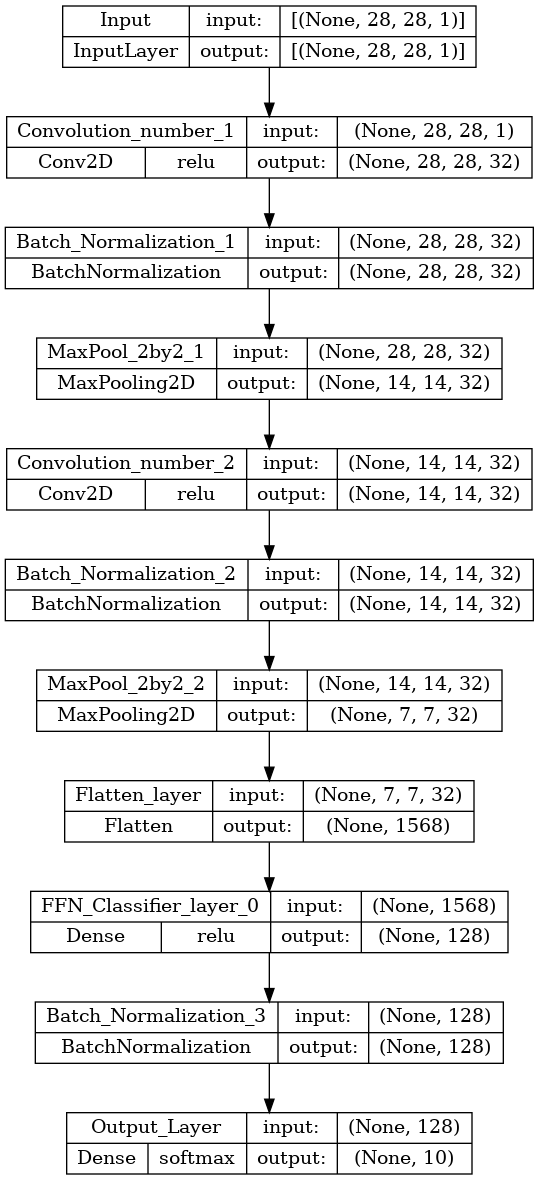

In [ ]:
# np.random.seed(42)
model = create_CNN_model(conv_layers=2 ,
                            head_layers=1, 
                            activation ='relu',
                            units = 128,
                            maxpooling = True,
                            batchnorm =True,
                            filters = 32)
model.save_weights('MNIST_classifier_CNN_model_starting_weights.h5')
#Early stopping callback to prevent overfitting
early_stopping = callbacks.EarlyStopping(patience = 3 , monitor="val_categorical_accuracy",restore_best_weights=True)
#Fit the model
model.fit(X_train,y_train, batch_size  = 64, epochs = 50, verbose=0, callbacks = [early_stopping], validation_data=(X_val,y_val))
#show the results
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test Accurarcy:',score[1])
model.save('MNIST_classifier_CNN_model.h5')
print(model.summary())
keras.utils.plot_model(model,show_layer_names=True,show_shapes=True,show_layer_activations=True)

We plot the confusion matrix. As we can see that $81$ out of the $10.0000$ patterns were misclassified

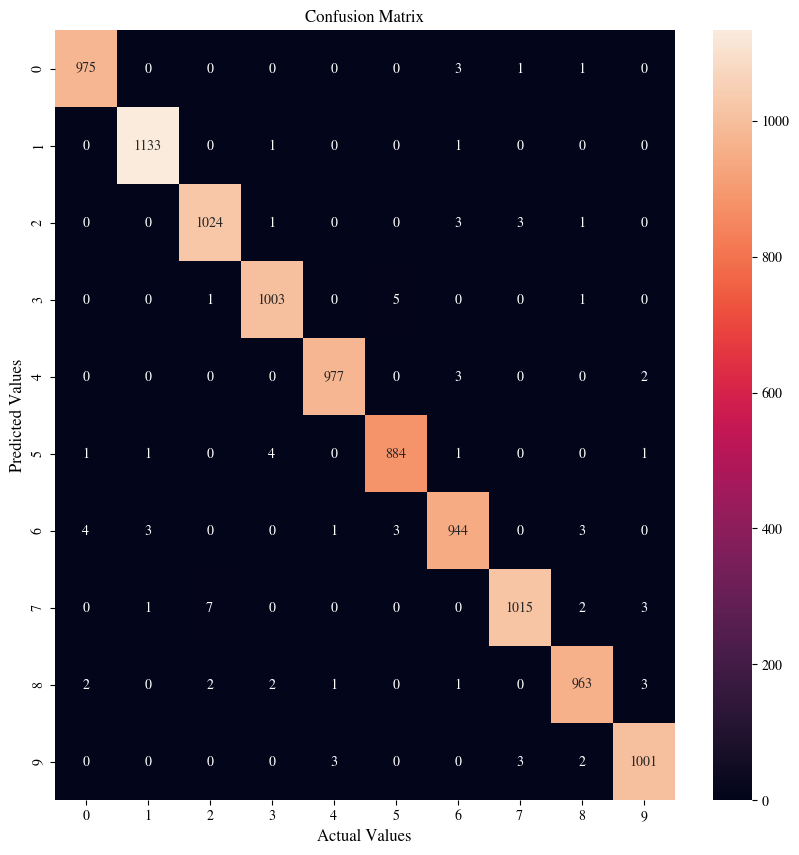

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test,verbose = 0)
y_pred_classes = np.argmax(y_pred, axis=1)
#Subset the wrong 

# create the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, cmap = "rocket",fmt='g')
plt.title("Confusion Matrix",fontsize=12)
plt.ylabel("Predicted Values",fontsize=12)
plt.xlabel("Actual Values",fontsize=12)
plt.show()

In [ ]:
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# extract the misclassified patterns
misclassified_idx = np.where(y_pred_classes != np.argmax(y_test, axis=1))[0]
print(f"There are {len(misclassified_idx)} misclassified patterns out of the {X_test.shape[0]} of the test set")
correct_idx = np.where(y_pred_classes == np.argmax(y_test, axis=1))[0]

There are 81 misclassified patterns out of the 10000 of the test set


### Quantative Predictor
We wish to gain more insight on the model's predictions, for this reason we construct the following predictor, which plots  the classfication certainty of the model for each digit prediction, along with the actual digit.

In [ ]:
def QPredictor(x,y,model,idx=None,verbose = False, MNIST = True):
    if MNIST:
        y_pred_certainty = model.predict(x[idx].reshape(1,28,28,1),verbose = 0)
        y_pred = np.argmax(y_pred_certainty,axis=1)
    else:
        y_pred_certainty = model.predict(x[idx].reshape(1,32,32,3),verbose = 0)
        y_pred = np.argmax(y_pred_certainty,axis=1)
    if verbose:
      fig, ax = plt.subplots(1,2,figsize=(8,4))
      ax[0].bar(x = np.arange(0,10,1),height = y_pred_certainty[0])
      ax[0].set_xticks(np.arange(0,10,1))
      ax[0].set_yticks(np.arange(0.0,1.1,0.1))
      ax[0].set_ylabel("Classification confidence",fontsize = 15)
      ax[0].set_xlabel("Class",fontsize = 15)
      ax[0].set_title("Predicted Class",fontsize = 15)
      ax[1].imshow(x[idx],cmap=plt.get_cmap('gray'))
      ax[1].set_xlabel(f"True Class: {np.argmax(y[idx])}",fontsize = 15)
      ax[1].set_title("Image",fontsize = 15)
    return y_pred

#### MNIST Correct classification examples
Below two examples of correct classification are shown , the model is very confident in its prediction and the certainty is close to 1.0.

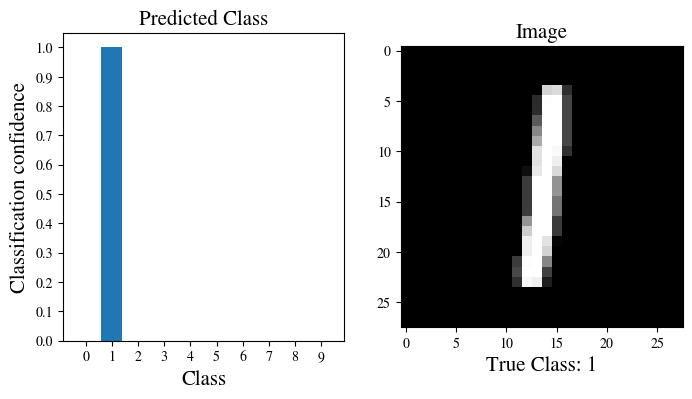

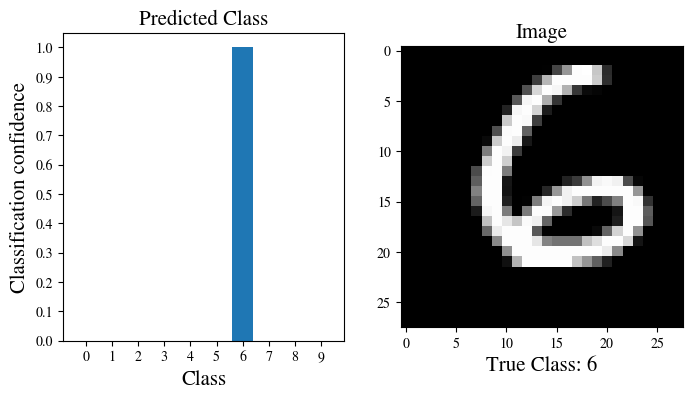

In [ ]:
np.random.seed(42)
#load the MNIST CNN model we built
model = keras.models.load_model('MNIST_classifier_CNN_model.h5')

for target_idx in np.random.randint((X_test.shape[0]), size=2):
    QPredictor(X_test, y_test, model = model, idx = target_idx, verbose = True)

#### MNIST Missclassification examples
Below we see two examples of missclassified digits: 
- The first one is labeled as 9 but the model  classifies it as 5 with high reatively confidence,however its important to notice that this digit would also confuse a human.
- The second example is an 8 misclassified as a 6. Again this is not a clearly defined digit a human would understand easily.

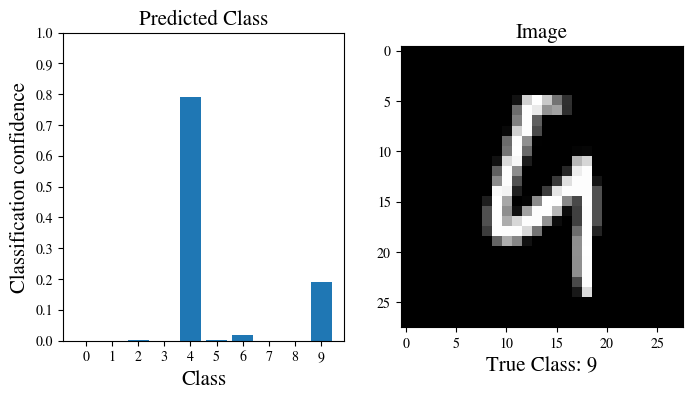

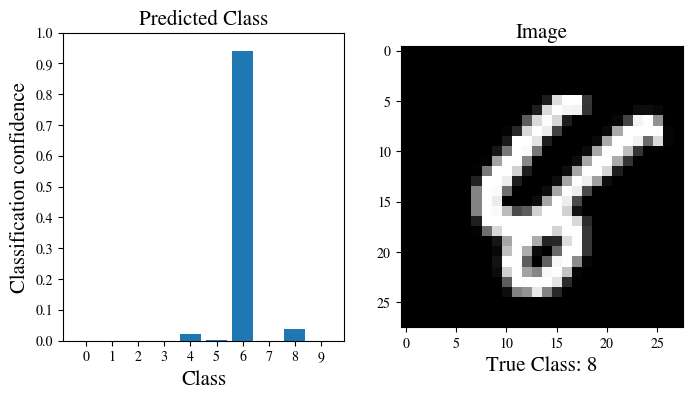

In [ ]:
np.random.seed(42)
for target_idx in misclassified_idx[np.random.randint((misclassified_idx.shape[0]), size=2)]:
    QPredictor(X_test,y_test,model=model,idx = target_idx,verbose = True)

## Classification Neural Network hyperparameter tuning for the CIFAR10 dataset

We begin with the architecture of the CNN model we complied for MNIST, is it enough for a good accuracy on the validation set?

Of course the layer shapes neeed to be tweaked since we now have 32x32 colored images rather than 28x28 grayscale.

In [ ]:
#change the input to 32 by 32 images with 3 channels
model = create_CNN_model(input_shape =(32,32,3),
                        conv_layers=2,
                        head_layers=1, 
                        activation ='relu',
                        units = 128,
                        maxpooling = True,
                        batchnorm =True,
                        filters = 32)
#Early stopping callback to prevent overfitting
early_stopping = callbacks.EarlyStopping(patience = 3 , monitor="val_categorical_accuracy",restore_best_weights=True)
#Fit the model
model.fit(X_train_1,y_train_1, batch_size  = 64, epochs = 50, verbose=0, callbacks = [early_stopping], validation_data=(X_val_1,y_val_1))
#show the results
score = model.evaluate(X_val_1, y_val_1, verbose=0)
print('Validation loss:', score[0])
print('Validation Accurarcy:',score[1])

Validation loss: 1.1300369501113892
Validation Accurarcy: 0.7128000259399414


Apparently not. CIFAR10 has higher complexity since its images are not grayscale sparse matrices as in MNIST but RGB full matrices. For this reason a more complexe model is required.

### Final CIFAR10 classification model
With the above observation in mind, we construct the final model and evaluate it on the test set. It achieves an accuracy of around $0.80\%$ which is satisfactory for the purpose of this notebook.
- We have doubled the number of nodes in the last layer and tripled the number of convolutional layers, additionally the size of the filter for each convolution layer was increased by 16. Finally a MaxPooling layer was added after each two convolutionla layers.

Test loss: 1.1313517093658447
Test Accurarcy: 0.8126999735832214
Model: "MNIST_classifier_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution_number_1 (Conv2  (None, 32, 32, 32)       2432      
 D)                                                              
                                                                 
 Batch_Normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 Convolution_number_2 (Conv2  (None, 32, 32, 48)       38448     
 D)                                                              
                                                                 
 Batch_Normalization_2 (Batc  (None, 32, 32, 48)       192       
 hNormalization)                                                 
                                         

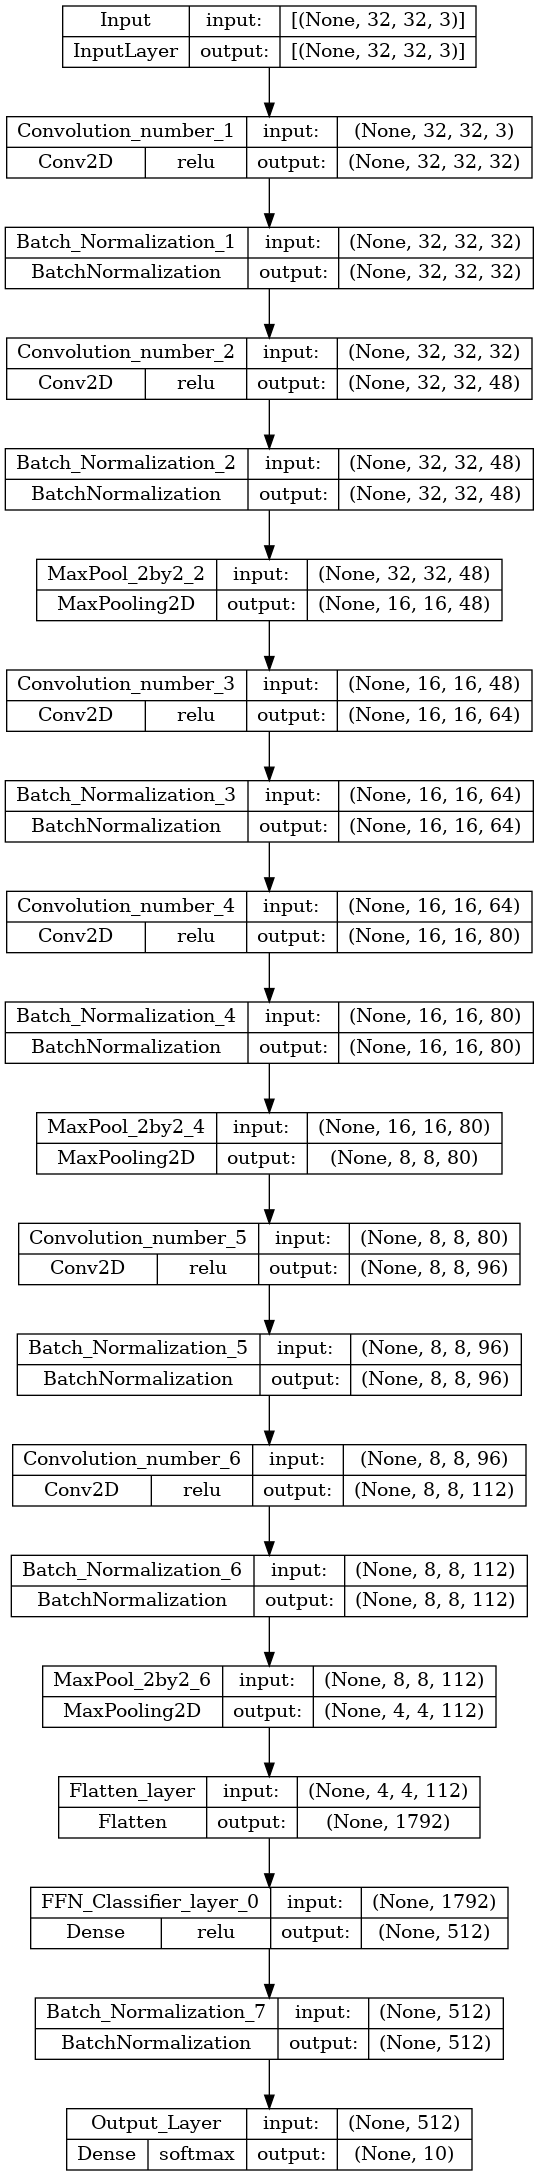

In [ ]:
# np.random.seed(42)
model = create_CNN_model(input_shape =(32,32,3),
                        conv_layers=6,
                        head_layers=1, 
                        activation ='relu',
                        units = 512,
                        maxpooling = True,
                        maxpooling_every_n_cov_layer = 2,
                        batchnorm =True,
                        filters = 32,
                        filters_increase_per_layer = 16)
model.save_weights('CIFAR10_classifier_CNN_model_starting_weights.h5')
#Early stopping callback to prevent overfitting
early_stopping = callbacks.EarlyStopping(patience = 8 , monitor="val_categorical_accuracy",restore_best_weights=True)
#Fit the model
model.fit(X_train_1,y_train_1, batch_size  = 64, epochs = 100, verbose=0, callbacks = [early_stopping], validation_data=(X_val_1,y_val_1))
#show the results
score = model.evaluate(X_test_1, y_test_1, batch_size= 64, verbose= 0)
print('Test loss:', score[0])
print('Test Accurarcy:',score[1])
model.save('CIFAR10_classifier_CNN_model.h5')
print(model.summary())
keras.utils.plot_model(model,show_layer_names=True,show_shapes=True,show_layer_activations=True)

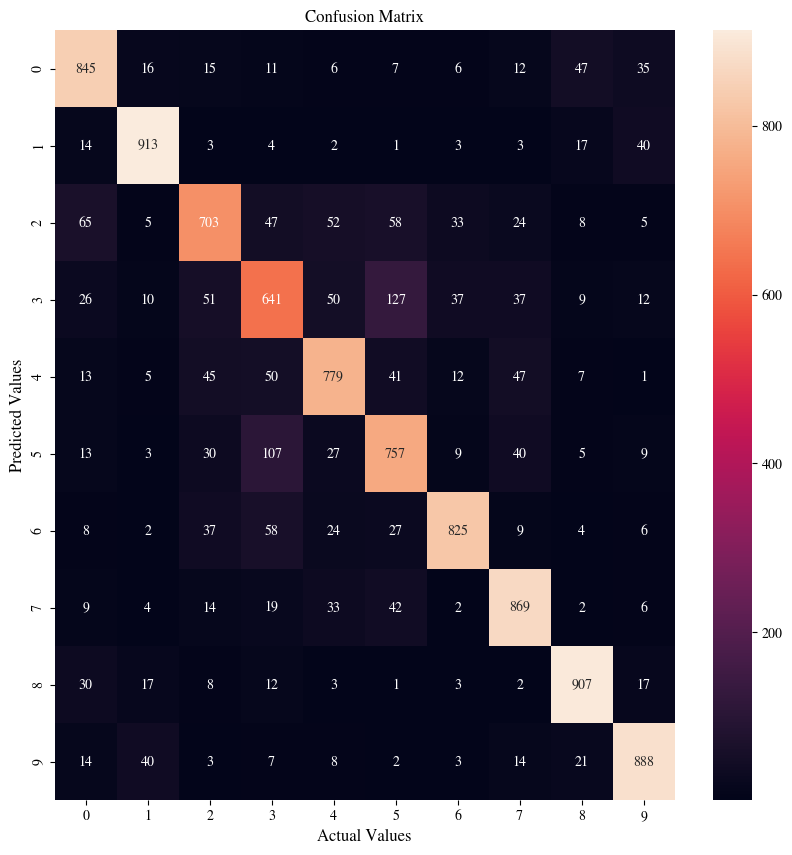

In [ ]:
#Load the CNN CIFAR10 model
model = keras.models.load_model('CIFAR10_classifier_CNN_model.h5')
y_pred = model.predict(X_test_1,verbose = 0)
y_pred_classes = np.argmax(y_pred, axis=1)
#Subset the wrong 

# create the confusion matrix
cm = confusion_matrix(np.argmax(y_test_1, axis=1), y_pred_classes)
plt.figure(figsize = (10,10))
sns.heatmap(cm, annot=True, cmap = "rocket",fmt='g')
plt.title("Confusion Matrix",fontsize=12)
plt.ylabel("Predicted Values",fontsize=12)
plt.xlabel("Actual Values",fontsize=12)
plt.show()

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
# extract the misclassified patterns
misclassified_idx_1 = np.where(y_pred_classes != np.argmax(y_test_1, axis=1))[0]
print(f"There are {len(misclassified_idx_1)} misclassified patterns out of the {X_test_1.shape[0]} of the test set")
correct_idx_1 = np.where(y_pred_classes == np.argmax(y_test_1, axis=1))[0]

There are 1873 misclassified patterns out of the 10000 of the test set


#### CIFAR10 correct classification examples
- In the first case the predicted class is 9:"Truck" with high confidence which is correct
- In the second case the predicted class is 4:"Deer, while this is the correct class the model is not very confident in this choice. It also predicted albeit with half the confidence that the image depicts a bird.

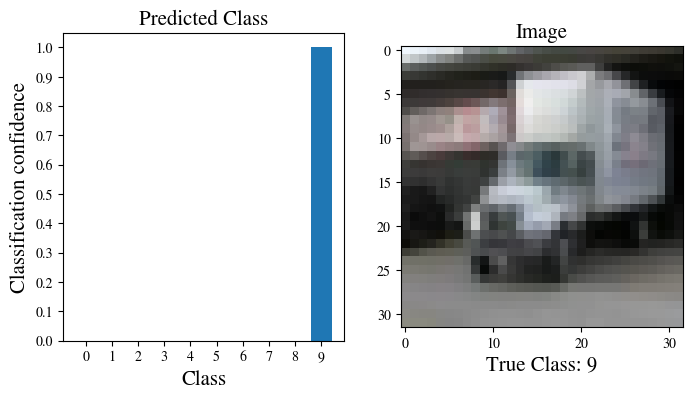

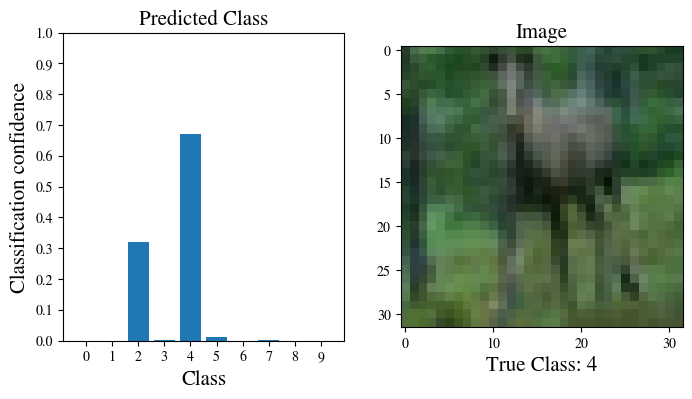

In [ ]:
np.random.seed(42)
for target_idx in np.random.randint((X_test_1.shape[0]), size=2):
    QPredictor(X_test_1, y_test_1,model = model,idx = target_idx, verbose = True,MNIST = False)

#### CIFAR10 Missclassification examples
- In this case the model mispredicts both of these images as class 4: "Deer"

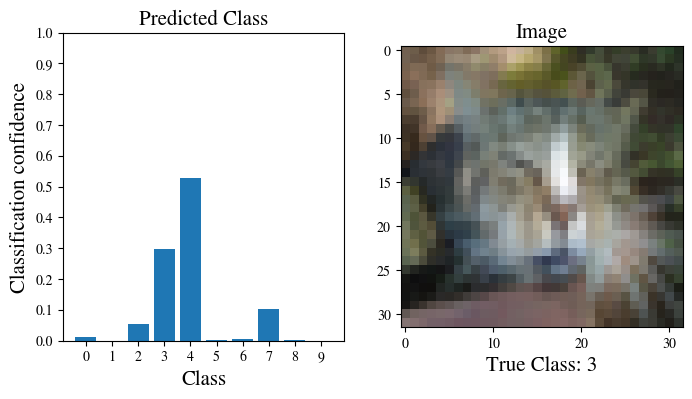

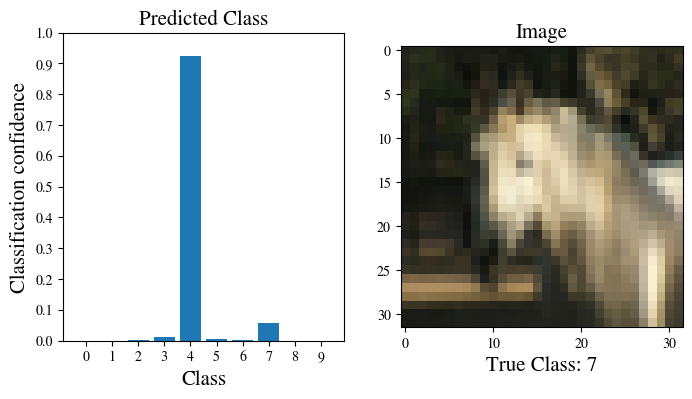

In [ ]:
np.random.seed(42)
for target_idx in misclassified_idx_1[np.random.randint((misclassified_idx_1.shape[0]), size=2)]:
    QPredictor(X_test_1,y_test_1,model=model,idx = target_idx,verbose = True,MNIST = False)

---
---

# Problem (B(i),(ii)) Adversarial Examples


- i) Choose your 5 favorite digits and take a sample for each from the MNIST dataset. Index these samples by i. Define a NIST-simple-generator fij as a keras model, constructing adversarial examples around instance i for class j. Compile your model to use the Adam optimizer and the mean squared error loss. Define also the composite model C ◦ f (C is the model you built in (A)),making sure that before you compile you disable training for all parameters in C. (Hint: You may want to use the Keras functional API). For each sample you picked and for each class 0-10, train fij in two steps, repeated as many times as necessary. First train fij with target equal to sample i. Then, train the composite model with target equal the one-hot encoding of j. Plot your adversarial examples together with the original image on a grid.

- ii) Repeat i) for one images from the CIFAR10 dataset

## Solution:

### Generator model 
The first step for the creation of adversarial examples is to create a generator model which takes a dummy input, a single intiger array in this case and maps it to a fake representation of an image from mnist which is created from random noise/wieghts after training on said image. 

In order to have the tools we need  from the keras functional API to train and predict with a generator model in one "place", we define the class `Generator`, which provides functionality for training, predicting and plotting the results.

- The `compile_generator` method creates and compiles the generator model with the adam optimizer and the mean squared error loss. Which will be used to train the generator model and make the fake image as close as possible to the true image. 
   - The MNIST generator architecture  is made of 2 dense layers one with 256 nodes and one which converts the input 2D (28 by 28) pixel information to 1D across all channels $28\cdot 28=784$ nodes respectively. The activation function is relu for the first two layers and sigmoid for the output layer since we need the output to be in the range [0,1] for the image to have a valid brightness. Finally we reshape the output to the original (28 by 28) shape. 
   
  - Similarly for the CIFAR10 generator with the difference of more nodes since the complexity is higher and the intermediate layer with $32\cdot 32\cdot 3=3072$ to convert the network multichannel information to their 1D representation.
   
   
- After compiling, we can train the generator on a batch of size one, which is the image we want to generate with the `batch_train` method. Setting it to verbose also reveals the image output of the generator after each 10 epochs.

- Finally we can create a fake image that is mapped to an input integer after training, with the `predict` method.

The main idea behind the generator is presented in the schematic below:

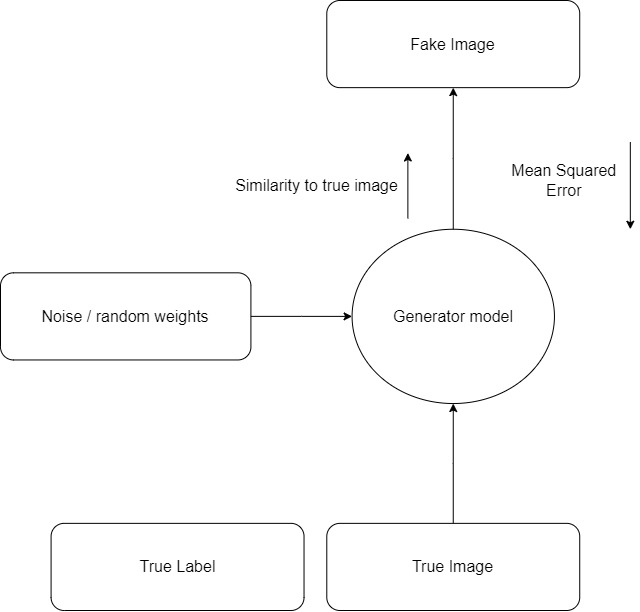

In [ ]:
class Generator():
  #Compile the MNIST generator
  def compile_MNIST_generator(self,verbose = False):
    #Generator Architecture    
    input = layers.Input(shape=(1,),name = 'Generator_Input_Index')  
    dense_1 = layers.Dense(256,activation='relu',name = 'Layer_1')(input)
    hidden_dense_2 = layers.Dense(28*28,activation = 'sigmoid',name ='Hidden_Layer')(dense_1)
    output = layers.Reshape((28,28,1),name ='Generator_Output_Image')(hidden_dense_2)
    #Create the Generator
    Generator = Model(input,output,name="MNIST_generator")
    Generator.compile(loss='mean_squared_error',
                      optimizer = 'adam',
                      metrics = ['mean_squared_error'])
    #Save the initial weights of the model
    Generator.save_weights('Generator_weights.h5')
    self.model = Generator
    if verbose:
      print(Generator.summary())
      keras.utils.plot_model(Generator,show_layer_names=True,show_shapes=True,show_layer_activations=True)
    
  #Compile the CIFAR10 generator  
  def compile_CIFAR10_generator(self,verbose = False):
    #Generator Architecture
    input = layers.Input(shape=(1,), name='Generator_Input_Index')
    dense_1 = layers.Dense(512, activation='relu', name='Layer_1')(input)
    hidden_dense_2 = layers.Dense(32*32*3, activation='sigmoid', name='Hidden_Layer')(dense_1)
    output = layers.Reshape((32, 32, 3), name='Generator_Output_Image')(hidden_dense_2)
    #Create the Generator
    Generator = Model(input,output,name="CIFAR10_generator")
    Generator.compile(loss='mean_squared_error',
                      optimizer = 'adam',
                      metrics = ['mean_squared_error'])
    #Save the initial weights of the model
    Generator.save_weights('Generator_weights.h5')
    self.model = Generator
    if verbose:
      print(Generator.summary())
      keras.utils.plot_model(Generator,show_layer_names=True,show_shapes=True,show_layer_activations=True)
  
  #reset the weights to the starting noise
  def reset_weights(self):
    self.model.load_weights('Generator_weights.h5')

  #Train the model on a sample image
  def batch_train(self,input_index,output_sample,epochs,verbose = 0):
    for epoch in range(epochs):
      history = self.model.train_on_batch(np.array([input_index]),np.array([output_sample]),reset_metrics=True)
      if verbose:
        if epoch % 10 == 0:
          print(f"Generator loss for epoch={epoch} is MSE={history[0]}")
          image = self.model.predict(np.array([input_index]),verbose=0)
          plt.imshow(image[0],cmap=plt.get_cmap('gray'))
          plt.show()

  # Create a fake image mapped to a single integer array input
  def predict(self,input_index,verbose = False, MNIST = True):
    y = self.model.predict(np.array([input_index]),verbose=0)
    if verbose and MNIST:
      plt.imshow(y[0],cmap=plt.get_cmap('gray'))
    elif verbose:
      plt.imshow(y[0])
    return y
  
  def save(self,filepath):
    self.model.save(filepath)

To solididy how the Generator works, below we showcase two examples: We map the input intiger array of $[1]$, to the second image of the training set for MNIST $X\_train[1]$ , which is the image of the number $6$ and the eighth image of the training set for CIFAR10 $X\_train\_1[7]$. Notice how the generator as the epochs pass and the loss decreases manages to create a fake representation of the image from noise.

Creating fake images for target classes (MNIST:6),(CIFAR10:7,horse) from Random Noise


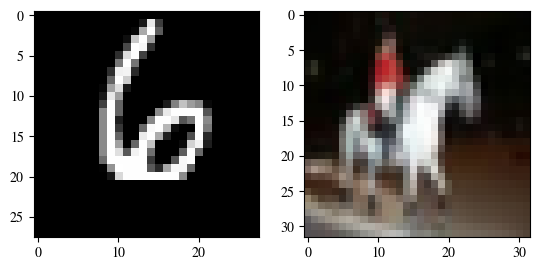


---------------
Beginning Generation of MNIST image:
---------------

Generator loss for epoch=0 is MSE=0.22983653843402863


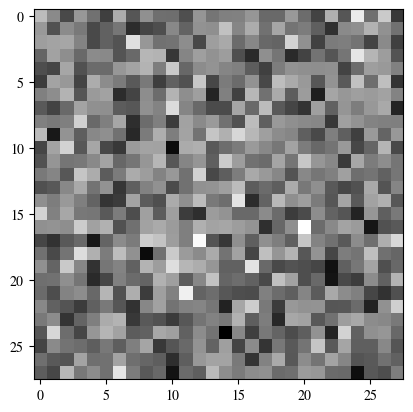

Generator loss for epoch=10 is MSE=0.20266078412532806


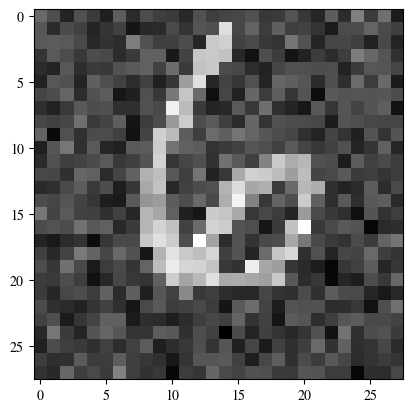

Generator loss for epoch=20 is MSE=0.16736844182014465


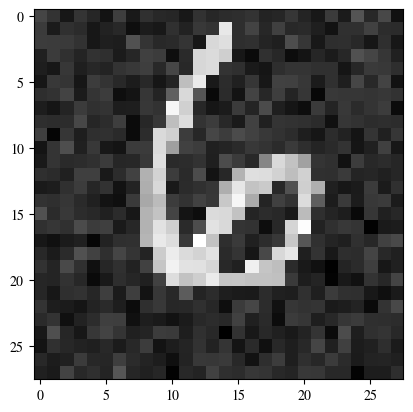

Generator loss for epoch=30 is MSE=0.12627451121807098


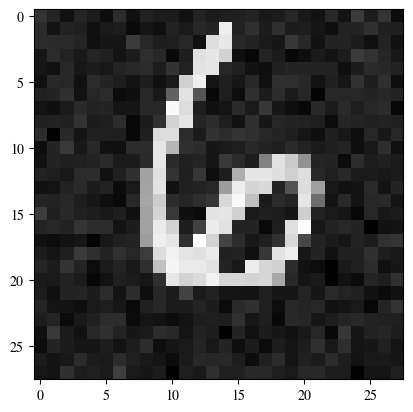

Generator loss for epoch=40 is MSE=0.08566910028457642


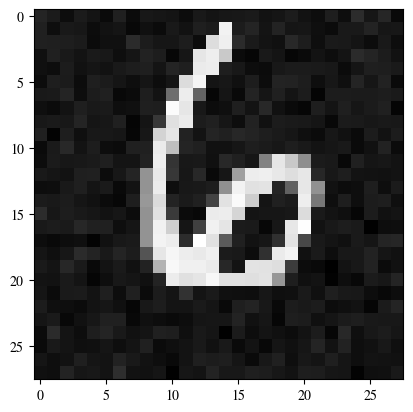

Generator loss for epoch=50 is MSE=0.052840352058410645


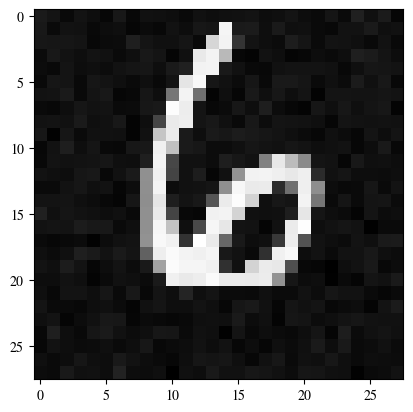

Generator loss for epoch=60 is MSE=0.03109912760555744


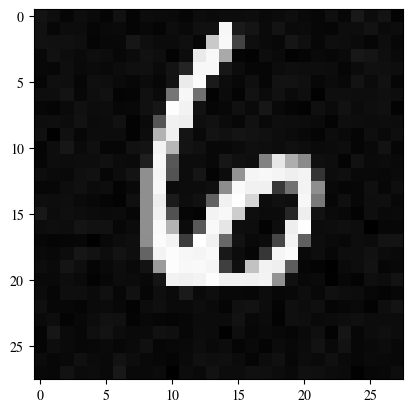

Generator loss for epoch=70 is MSE=0.018649229779839516


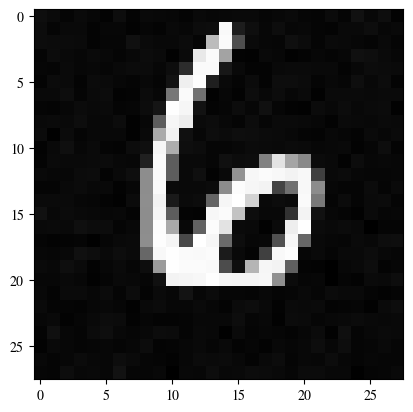

Generator loss for epoch=80 is MSE=0.011921688914299011


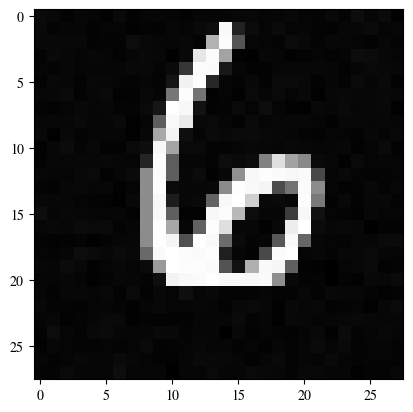


---------------
Beginning Generation of CIFAR10 image:
---------------

Generator loss for epoch=0 is MSE=0.1274760514497757


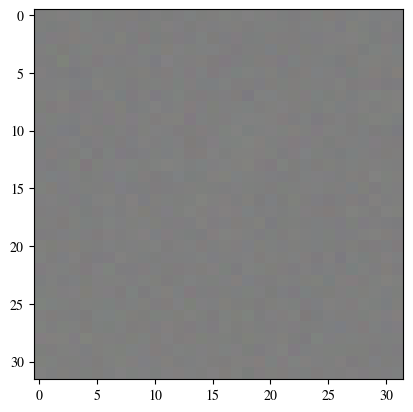

Generator loss for epoch=10 is MSE=0.10584428906440735


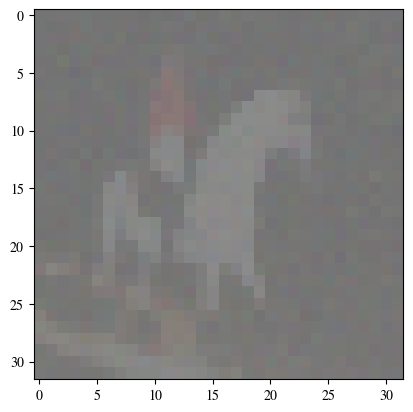

Generator loss for epoch=20 is MSE=0.07380878925323486


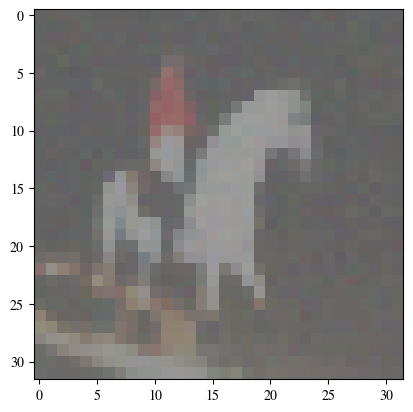

Generator loss for epoch=30 is MSE=0.040229834616184235


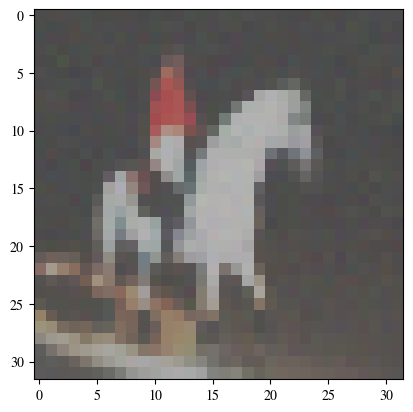

Generator loss for epoch=40 is MSE=0.01727863773703575


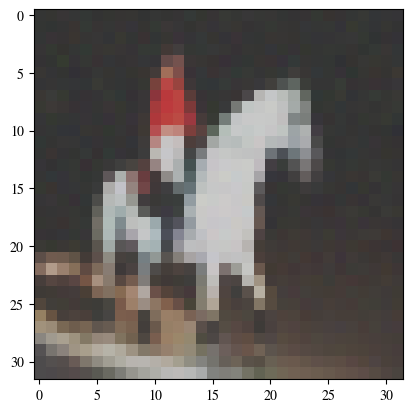

Generator loss for epoch=50 is MSE=0.007048396393656731


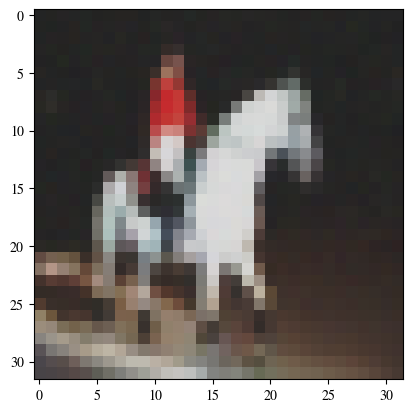

Generator loss for epoch=60 is MSE=0.0032954735215753317


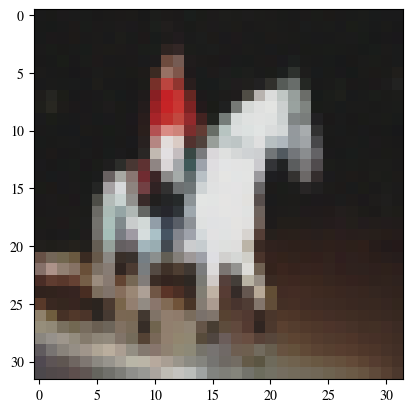

Generator loss for epoch=70 is MSE=0.001823769067414105


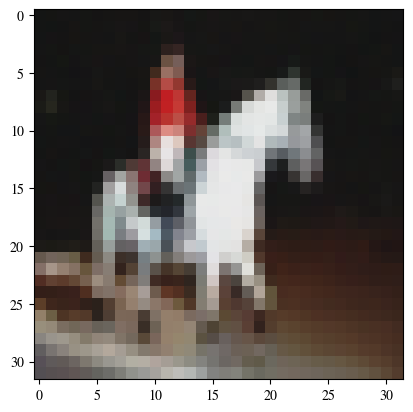

Generator loss for epoch=80 is MSE=0.0011516640661284328


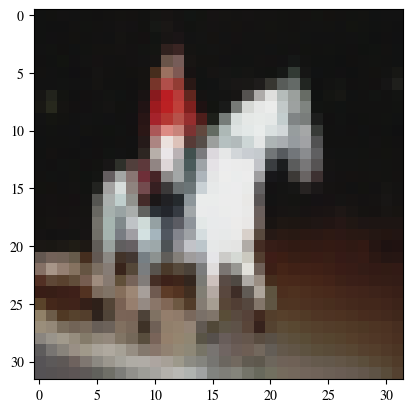

In [ ]:
MNIST_generator = Generator()
MNIST_generator.compile_MNIST_generator()
CIFAR10_generator = Generator()
CIFAR10_generator.compile_CIFAR10_generator()

print(f"Creating fake images for target classes (MNIST:{np.argmax(y_train[1])}),(CIFAR10:{np.argmax(y_train_1[7])},horse) from Random Noise")
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_train[1],cmap=plt.get_cmap('gray'))
ax[1].imshow(X_train_1[7])
plt.show()
print("\n---------------\nBeginning Generation of MNIST image:\n---------------\n")
MNIST_generator.batch_train(1,X_train[1],epochs = 81,verbose = True)
print("\n---------------\nBeginning Generation of CIFAR10 image:\n---------------\n")
CIFAR10_generator.batch_train(1,X_train_1[7],epochs = 81,verbose = True)      

### Adversarial Example Generator + Frozen classifier composite model

Having constructed a generator model, we have a way to create fake images that are very close to the real ones, however this is not our goal. We want to create fake images that look like the real ones $\textbf{AND}$ are misclassified by the model. For this reason we need to create a composite model, which is a combination of the respective generator model and a frozen version of the CNN classifier model for the MNIST and CIFAR10 data-sets we compiled in problem (A). 

The class `Adversarial_generator` is defined with functionality similar to the `Generator` class. The main difference is the addition of the frozen classifier head to the generator base.

The intuiton behind a composite model of generator + frozen classifier can be explained in two steps as follows:

Through simultaneous training of the generator and the composite model:
1. We minimize the mean squared error loss of the generator model, this trains the weights of the generator to create fake images that are as close as possible to the real ones.
2. We minimize the categorical crossentropy loss of the composite model, this does not train the weights of the frozen classifier but trains again the generator to create an image that is classified to the specified target of the frozen classifier, since the fake image is passed as input to the classifier. 
3. Finally by setting the target of the composite model to the one-hot encoded representation of a digit different than the true target of the true image, we train the generator to create an image that is classified to the specified misclassification target of the frozen classifier, while still being as close as possible to the real image.

To solididy this intuition the following schematic showcases the training proccess of the composite model and its affect to the fake image output:

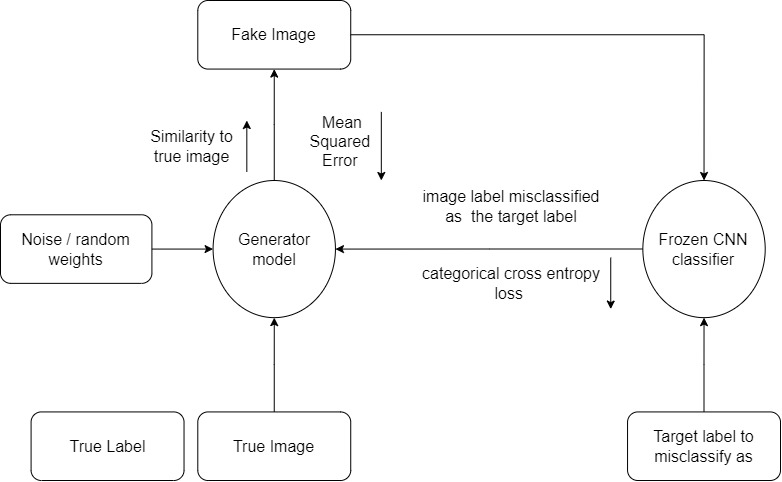

In [ ]:
class Adversarial_generator():
    
  #Complile the MNIST composite model
  def compile_MNIST_model(self,classifier_path,verbose = False):
    #Load the classifier
    self.frozen_classifier = keras.models.load_model(classifier_path)
    #Freeze the classifier so its not trained
    self.frozen_classifier.trainable = False
    #Generator
    input = layers.Input(shape=(1,),name = 'Generator_Input_Index')  
    dense_1 = layers.Dense(256,activation='relu',name = 'Layer_1')(input)
    hidden_dense_2 = layers.Dense(28*28,activation = 'sigmoid',name ='Hidden_Layer')(dense_1)
    output = layers.Reshape((28,28,1),name ='Generator_Output_Image')(hidden_dense_2)
    adv_generator = Model(input,output,name="MNIST_generator")
    adv_generator.compile(loss='mean_squared_error',
                      optimizer = 'adam',
                      metrics = ['mean_squared_error'])
    #Frozen_classifier
    composite = Model(input, self.frozen_classifier(output),name = f'Frozen_Classifier')
    composite.compile(loss = 'categorical_crossentropy',
                      optimizer ='adam',
                      metrics='categorical_accuracy')
    #Save the original weights
    adv_generator.save_weights('adv_generator_weights.h5')
    composite.save_weights('composite_weights.h5')
    self.generator = adv_generator
    self.composite = composite
    if verbose:
       print(self.composite.summary())

  #Compile the CIFAR10 composite model  
  def compile_CIFAR10_model(self,classifier_path,verbose = False):
    #Load the classifier
    self.frozen_classifier = keras.models.load_model(classifier_path)
    #Freeze the classifier so its not trained
    self.frozen_classifier.trainable = False
    #Generator
    input = layers.Input(shape=(1,), name='Generator_Input_Index')
    dense_1 = layers.Dense(512, activation='relu', name='Layer_1')(input)
    hidden_dense_2 = layers.Dense(32*32*3, activation='sigmoid', name='Hidden_Layer')(dense_1)
    output = layers.Reshape((32, 32, 3), name='Generator_Output_Image')(hidden_dense_2)
    adv_generator = Model(input,output,name="CIFAR10_generator")
    adv_generator.compile(loss='mean_squared_error',
                      optimizer = 'adam',
                      metrics = ['mean_squared_error'])
    #Frozen_classifier
    composite = Model(input, self.frozen_classifier(output),name = f'Frozen_Classifier')
    composite.compile(loss = 'categorical_crossentropy',
                      optimizer ='adam',
                      metrics='categorical_accuracy')
    #Save the original weights
    adv_generator.save_weights('adv_generator_weights.h5')
    composite.save_weights('composite_weights.h5')
    self.generator = adv_generator
    self.composite = composite
    if verbose:
       print(self.composite.summary())    

  #reset the weights to original noise
  def reset_weights(self,path_to_generator_weights = 'adv_generator_weights.h5', path_to_composite_weights = 'composite_weights.h5'):
    self.generator.load_weights(path_to_generator_weights)
    self.composite.load_weights(path_to_composite_weights)
  
  #Train
  def batch_train(self,X,y,input_index,output_sample_index,classifier_output_target,epochs):
    self.X_pos = X[output_sample_index]
    self.y_pos = y[output_sample_index]
    self.output_sample_index = output_sample_index
    self.classifier_output_target = classifier_output_target
    for epoch in range(epochs):
      self.generator.train_on_batch(np.array([input_index]),np.array([self.X_pos]))
      self.composite.train_on_batch(np.array([input_index]),np.array([np_utils.to_categorical(self.classifier_output_target,10),]))

  #Predict and return results
  def predict(self,input_index):
    generator_output = self.generator.predict(np.array([input_index]),verbose= 0)
    classifier_output = self.frozen_classifier.predict(generator_output,verbose=0)
    return generator_output,classifier_output 

  def save(self,filepath):
    self.composite.save(filepath)
    self.generator.save(filepath)


### Real image samples for Adversarial training:

#### MNIST sample images
First we pick a sample of digits, for classes 5 to 9 of MNIST. Of course we make sure that the samples chosen belong to the $99%$ of the test set which is correctly classified:

Sample selected:{5: 102, 6: 88, 7: 64, 8: 179, 9: 73}


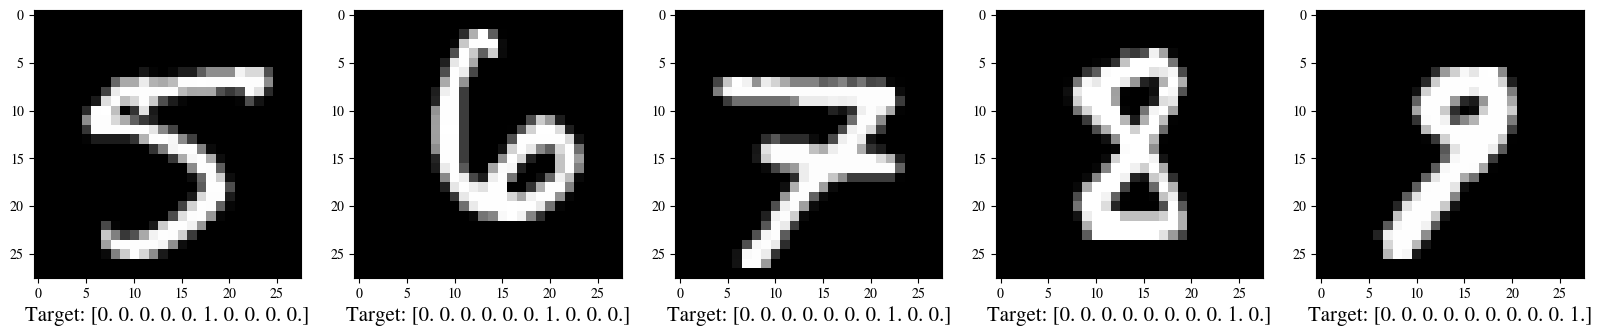

In [ ]:
# Pick a single sample for digits 5 to 9
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
samples_dict = {}
for digit in [5,6,7,8,9]:
  samples_dict[digit] = np.where(np.argmax(y_test,axis = 1) == digit )[0][7]
  for i,index in enumerate(samples_dict.values()):
    # Cehck if the true image was correctly classified
    if index in misclassified_idx:
      print("Select another sample, this was not classified correctly by the model")
      break
    else:
        ax[i].imshow(X_test[index],cmap=plt.get_cmap('gray'))
        ax[i].set_xlabel(f"Target: {y_test[index]}",fontsize = 15)
print(f'Sample selected:{samples_dict}')

These digits seem clear, so we select them for our sample digits, their corresponding index at the test set is:
- 5 $→$ 102
- 6 $→$ 88
- 7 $→$ 64
- 8 $→$ 179
- 9 $→$ 73

#### CIFAR10 sample image
Similarly we pick a sample images from CIFAR10. Of course we make sure that the sample chosen belongs to the $80%$ of the test set which is correctly classified:

Is the image misclassified by the model? False


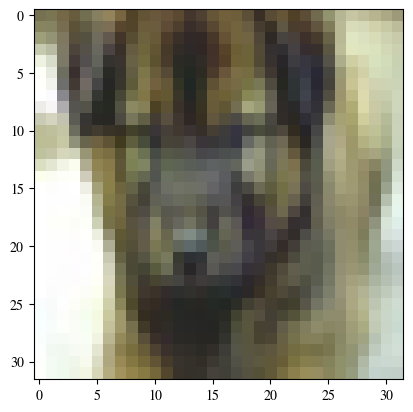

In [ ]:
cifar_img = X_test_1[33]
print(f"Is the image misclassified by the model? {33 in misclassified_idx_1}")
plt.imshow(cifar_img)
plt.show()

Finally:
- For the single sample image from the CIFAR10 datase we train the Adversarial model we create fake images that are misclassified as: 0-airplane, 1-automobile, 2-bird, 3-cat, 4-deer, 5-dog, 6-frog, 7-horse, 8-ship, 9-truck.
- for each sample from the MNIST dataset we train the Adversarial model, to create fake images that are misclassified as digits $0,1,2,3,4,5,6,7,8,9$ respectively

# CIFAR10 Adversarial Examples showcase:

In [ ]:
#create an instances of the avdersarial model for CIFAR10 dataset
CIFAR10_Adversarial_examples = Adversarial_generator()
CIFAR10_Adversarial_examples.compile_CIFAR10_model('CIFAR10_classifier_CNN_model.h5')

print("Adversarial generator compiled successfully")

Adversarial generator compiled successfully


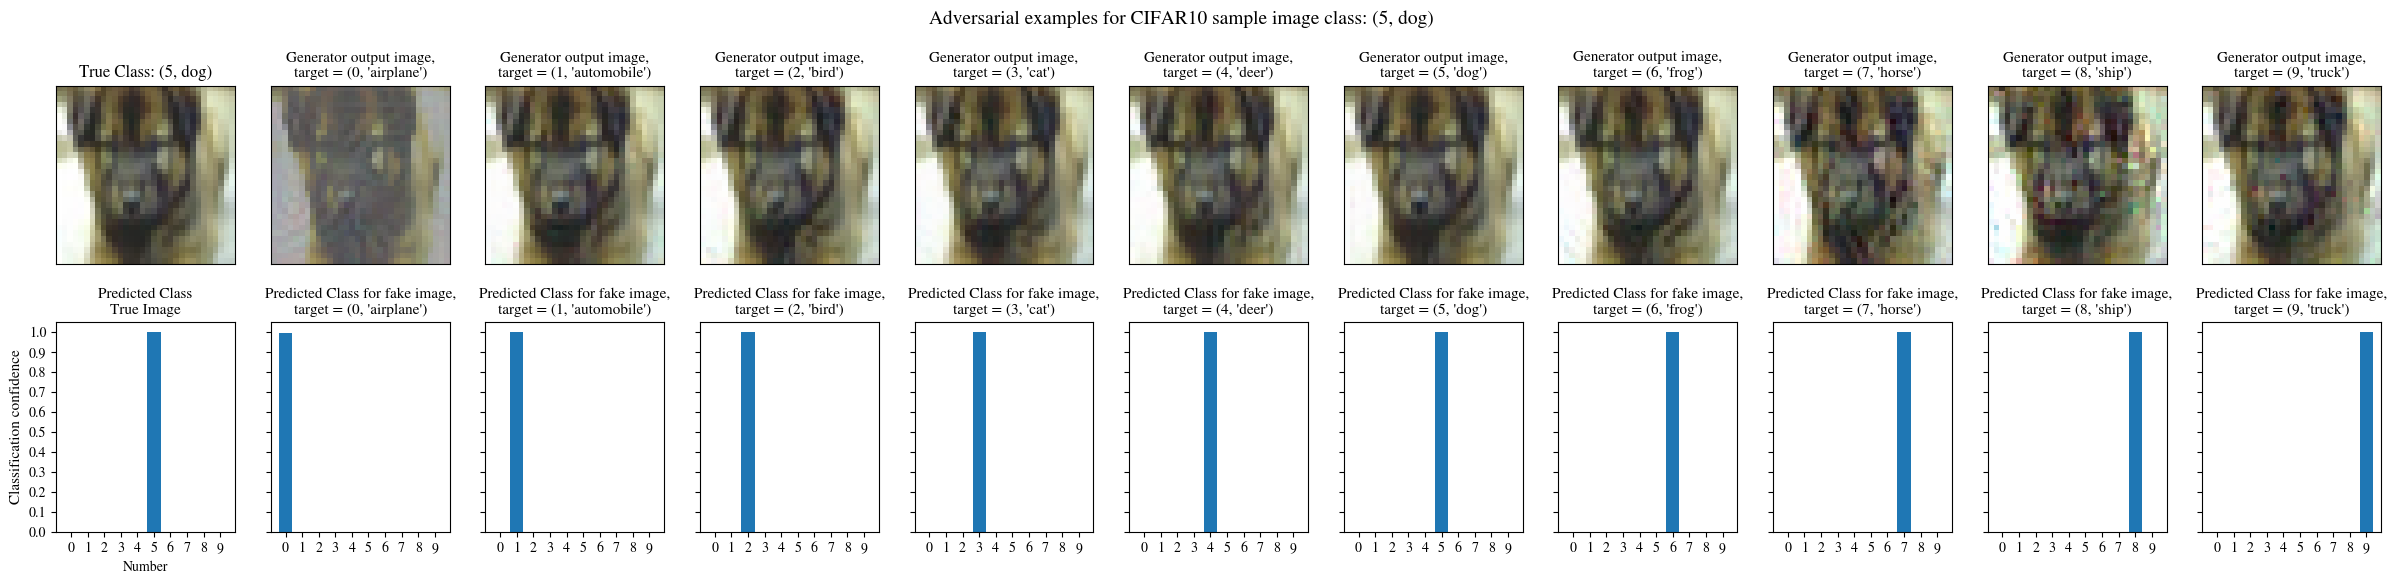

In [ ]:
classes = dict(zip(np.unique(np.argmax(y_train_1,axis=1)),['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))
y_one_hot = y_test_1[33]
y_img = np.argmax(y_one_hot)
X_image = X_test_1[33]
fig, ax = plt.subplots(2,11,figsize=(30,6),sharey = 'row')
fig.suptitle("Adversarial examples for CIFAR10 sample image class: (5, dog)\n",fontsize = 14)
ax[1,0].bar(x = np.arange(0,10,1),height = y_one_hot)
ax[1,0].set_xticks(np.arange(0,10,1))
ax[1,0].set_yticks(np.arange(0.0,1.1,0.1))
ax[1,0].set_ylabel("Classification confidence",fontsize = 11)
ax[1,0].set_xlabel("Number")
ax[1,0].set_title("Predicted Class\nTrue Image",fontsize = 11)
#True image
ax[0,0].imshow(X_image,cmap=plt.get_cmap('gray'))
ax[0,0].set_title(f"True Class: (5, dog)")
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
for misclassification_target,name in enumerate(classes.values()):
     CIFAR10_Adversarial_examples.reset_weights()
     CIFAR10_Adversarial_examples.batch_train(input_index = misclassification_target,
                                              X = X_test_1, 
                                              y = y_test_1,
                                              output_sample_index = 33,
                                              classifier_output_target = misclassification_target,
                                              epochs = 800)
     generator_output, classifier_output = CIFAR10_Adversarial_examples.predict(input_index = misclassification_target)
     #Classification confidence on the generator output
     ax[1,1+misclassification_target].bar(x = np.arange(0,10,1),height = classifier_output[0])
     ax[1,1+misclassification_target].set_xticks(np.arange(0,10,1))
     ax[1,1+misclassification_target].set_yticks(np.arange(0.0,1.1,0.1))
     ax[1,1+misclassification_target].set_title(f"Predicted Class for fake image,\ntarget = {misclassification_target, name}",fontsize = 11)
     #Generator Ouput
     ax[0,1+misclassification_target].imshow(generator_output[0],cmap=plt.get_cmap('gray'))
     ax[0,1+misclassification_target].set_title(f"Generator output image,\ntarget = {misclassification_target, name}",fontsize = 11)
     ax[0,1+misclassification_target].set_xticks([])
     ax[0,1+misclassification_target].set_yticks([])
plt.show()

# MNIST Adversarial Examples showcase:

In [ ]:
#create an instances of the avdersarial model for CIFAR10 dataset
MNIST_Adversarial_examples = Adversarial_generator()
MNIST_Adversarial_examples.compile_MNIST_model('MNIST_classifier_CNN_model.h5')

print("Adversarial generator compiled successfully")

Adversarial generator compiled successfully



------------------
Beginning training to create adversarial examples for sample digit: 5
------------------



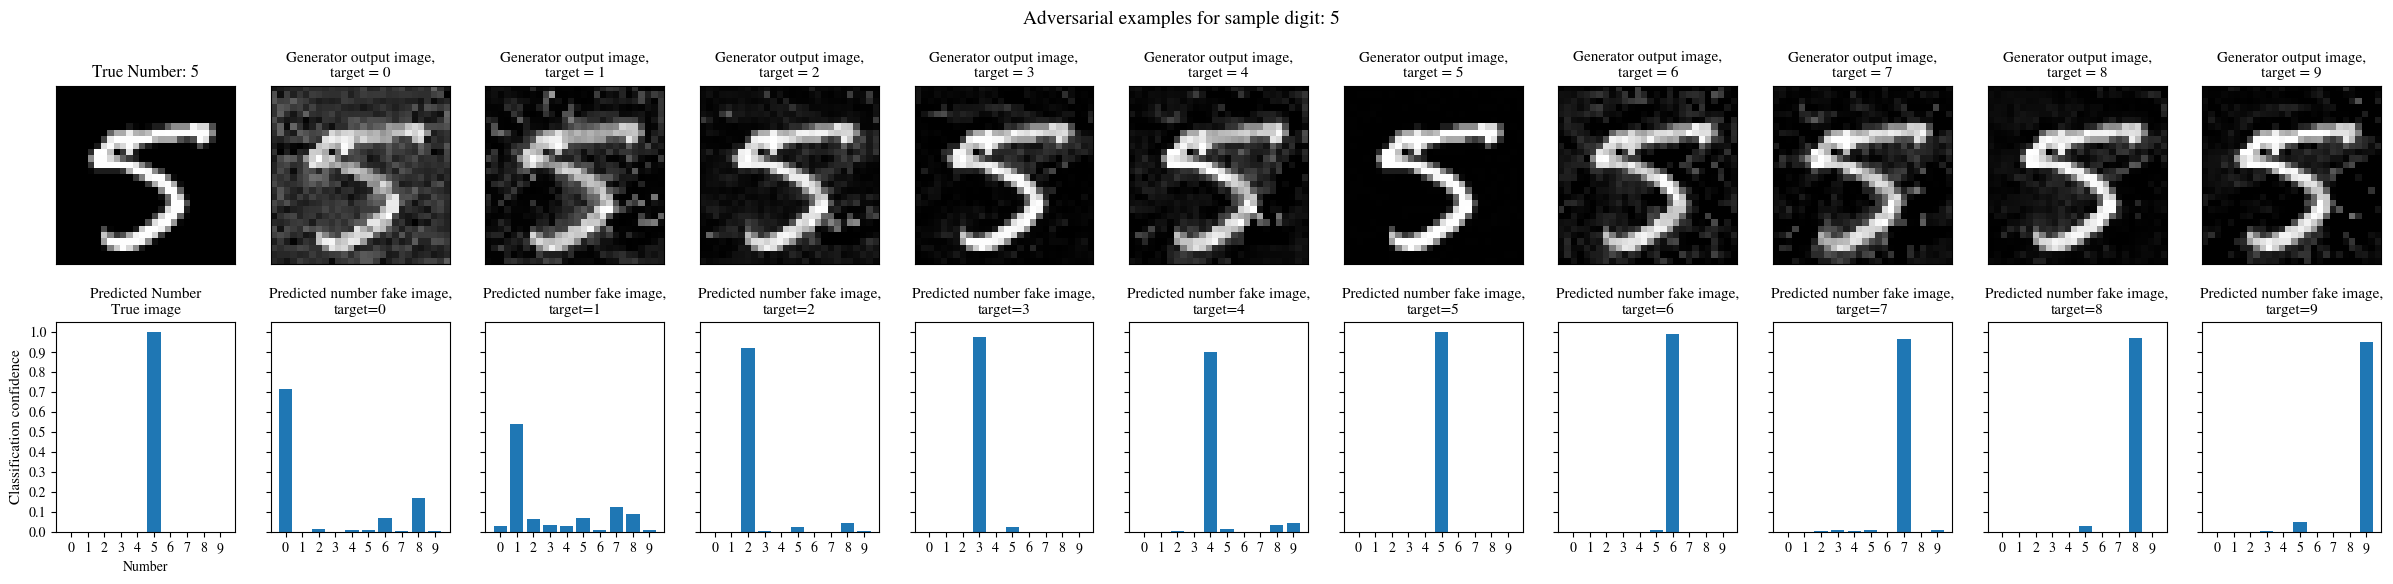


------------------
Beginning training to create adversarial examples for sample digit: 6
------------------



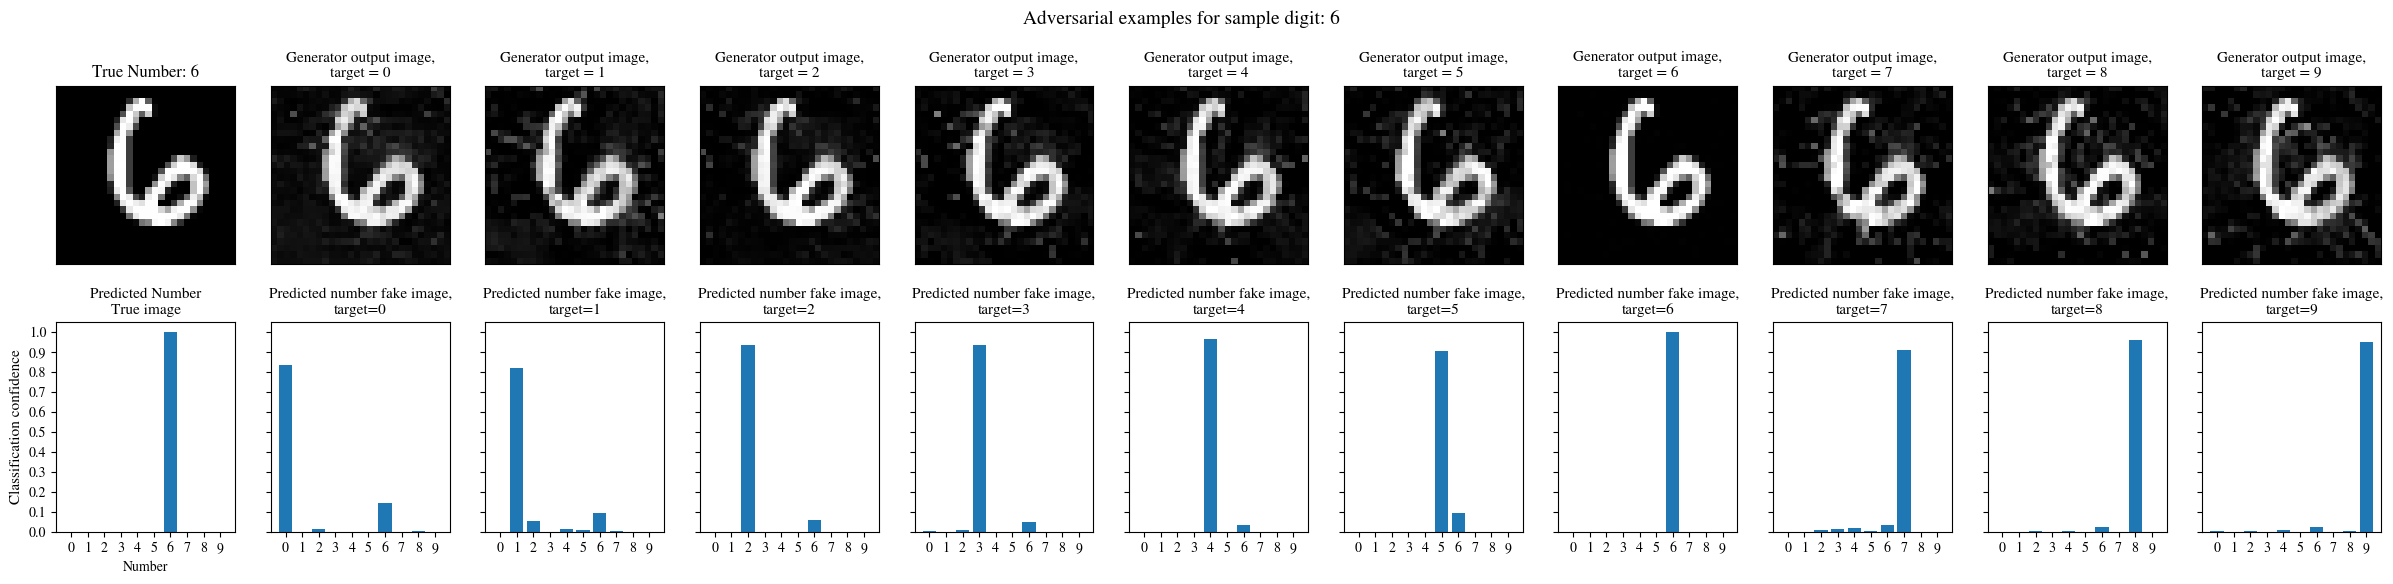


------------------
Beginning training to create adversarial examples for sample digit: 7
------------------



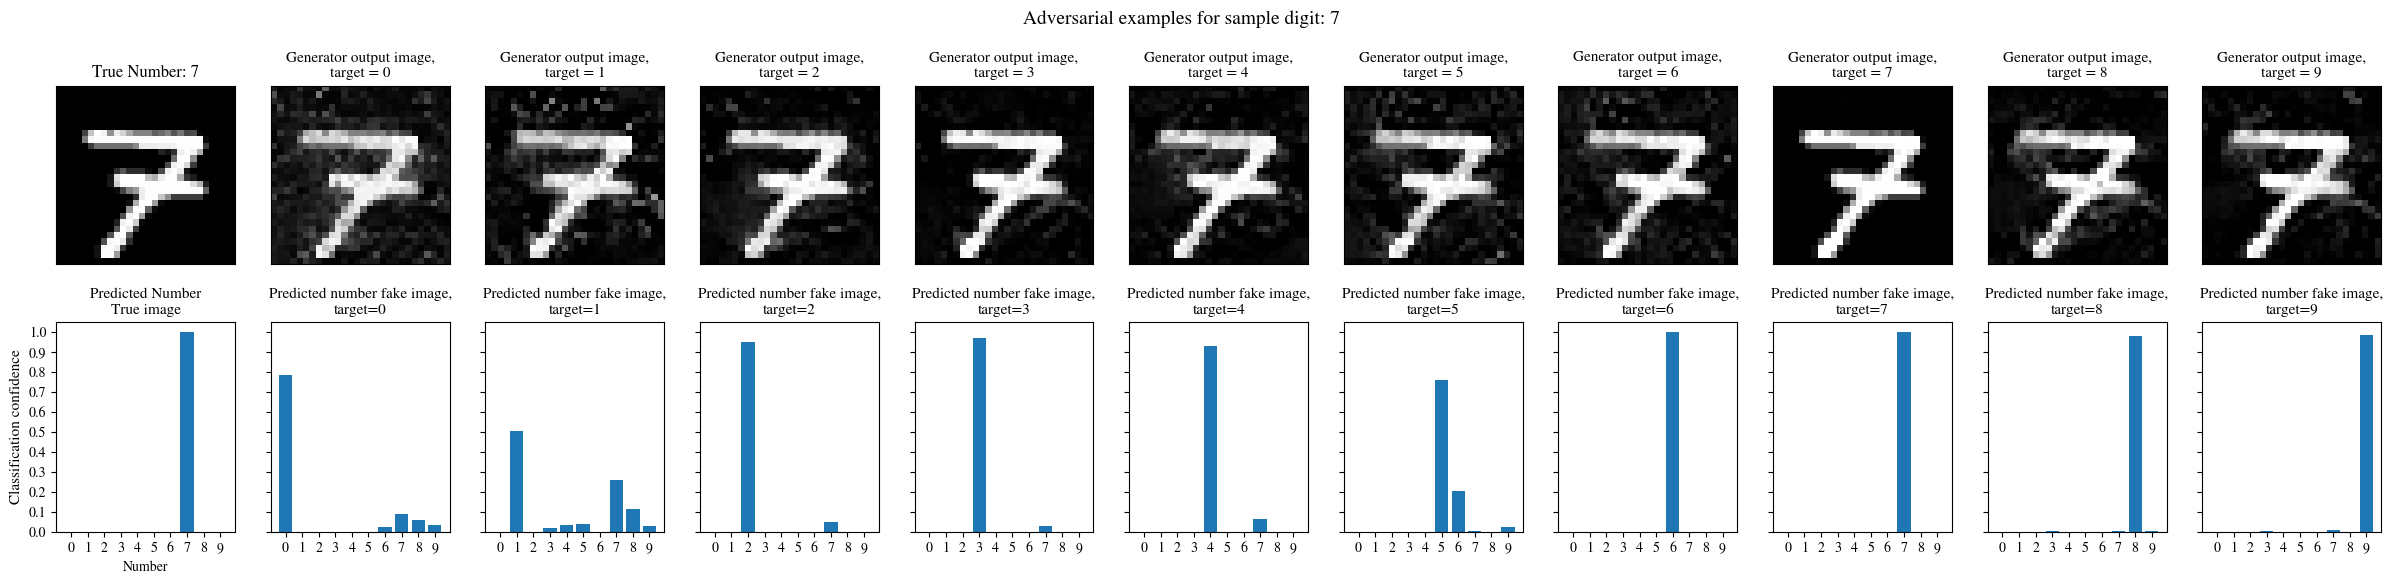


------------------
Beginning training to create adversarial examples for sample digit: 8
------------------



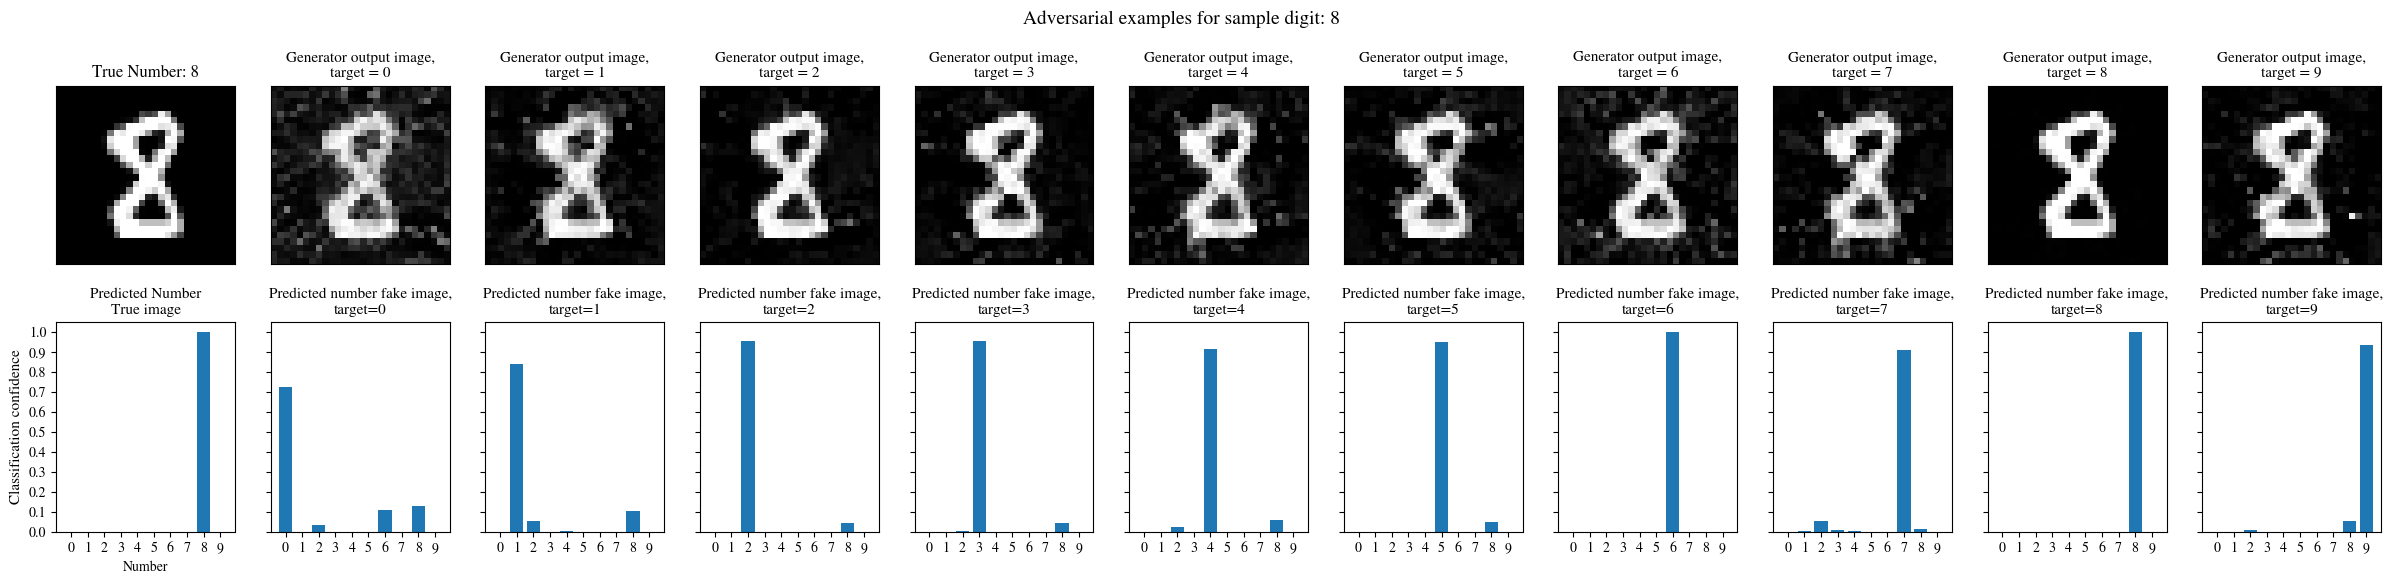


------------------
Beginning training to create adversarial examples for sample digit: 9
------------------



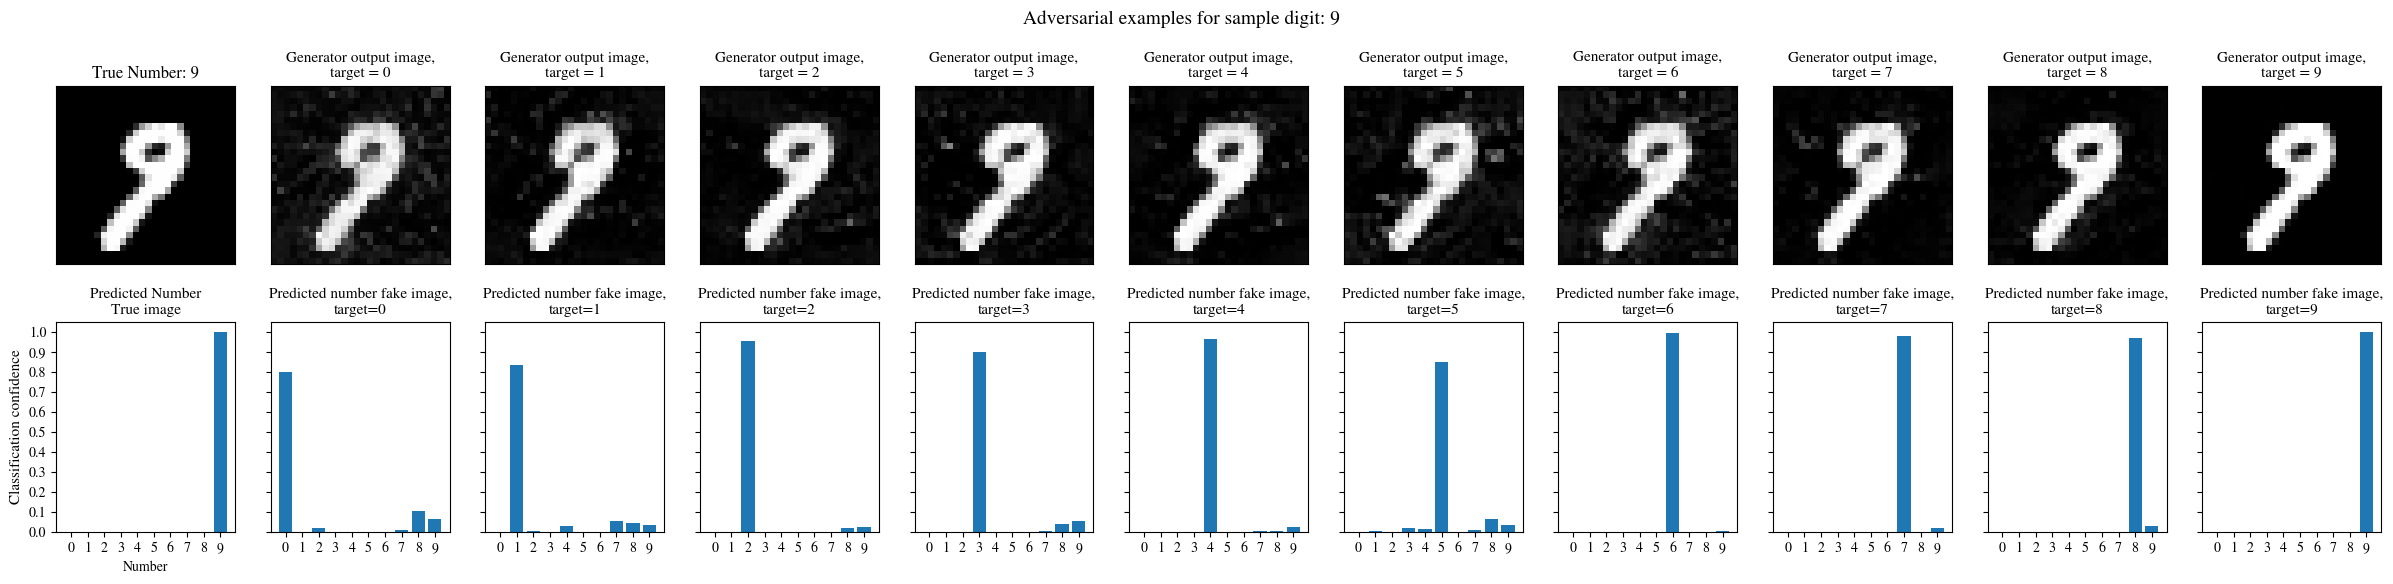

In [ ]:
for sample_idx in [102,88,64,179,73]:
    y_one_hot = y_test[sample_idx]
    y_digit  = np.argmax(y_one_hot)
    X_image = X_test[sample_idx]
    print(f"\n------------------\nBeginning training to create adversarial examples for sample digit: {y_digit}\n------------------\n")
    fig, ax = plt.subplots(2,11,figsize=(30,6),sharey = 'row')
    fig.suptitle(f"Adversarial examples for sample digit: {y_digit}\n",fontsize = 14)
    #True Prediction
    ax[1,0].bar(x = np.arange(0,10,1),height = y_one_hot)
    ax[1,0].set_xticks(np.arange(0,10,1))
    ax[1,0].set_yticks(np.arange(0.0,1.1,0.1))
    ax[1,0].set_ylabel("Classification confidence",fontsize = 11)
    ax[1,0].set_xlabel("Number")
    ax[1,0].set_title("Predicted Number\nTrue image",fontsize = 11)
    #True image
    ax[0,0].imshow(X_image,cmap=plt.get_cmap('gray'))
    ax[0,0].set_title(f"True Number: {y_digit}")
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    for misclassification_target in [0,1,2,3,4,5,6,7,8,9]:
        #Reset the weights
        MNIST_Adversarial_examples.reset_weights()
        MNIST_Adversarial_examples.batch_train(input_index = misclassification_target,
                                              X = X_test, 
                                              y = y_test,
                                              output_sample_index = sample_idx,
                                              classifier_output_target = misclassification_target,
                                              epochs = 800)
        generator_output, classifier_output = MNIST_Adversarial_examples.predict(input_index = misclassification_target)
        #Classification confidence on the generator output
        ax[1,1+misclassification_target].bar(x = np.arange(0,10,1),height = classifier_output[0])
        ax[1,1+misclassification_target].set_xticks(np.arange(0,10,1))
        ax[1,1+misclassification_target].set_yticks(np.arange(0.0,1.1,0.1))
        ax[1,1+misclassification_target].set_title(f"Predicted number fake image,\ntarget={misclassification_target}",fontsize = 11)
        #Generator Ouput
        ax[0,1+misclassification_target].imshow(generator_output[0],cmap=plt.get_cmap('gray'))
        ax[0,1+misclassification_target].set_title(f"Generator output image,\ntarget = {misclassification_target}",fontsize = 11)
        ax[0,1+misclassification_target].set_xticks([])
        ax[0,1+misclassification_target].set_yticks([])
    plt.show()